# Convergence Burst Semantic Embeddings

In [2]:
from pathlib import Path
import pandas as pd

# This assumes your current working directory is /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Notebook
data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

print(f"Loading from: {data_path.resolve()}")
df = pd.read_csv(data_path)



Loading from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embedding = model.encode(["This works!"])
print(embedding.shape)


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(1, 384)


In [4]:
import pandas as pd
from pathlib import Path

# Hardcode the known correct path
data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Confirm path exists (debug step)
print(f"Trying to load from: {data_path}")
print("File exists:", data_path.exists())

# Load the file
utterance_data_aligned = pd.read_csv(data_path)
utterance_data_aligned.head()


Trying to load from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv
File exists: True


,conference,session,speaker,timestamp,speaking_duration,nods_others,smile_self,smile_other,distracted_others,hand_gesture,...,start_sec_adjusted,end_sec_adjusted,start_minute_adjusted,global_timestamp_sec,global_minute,is_early,annotation_dict,has_new_idea,has_explanation,has_decision
0,2021_04_22_MND_S5,2021_04_22_MND_S5,Jill Marburger,00:00-00:13,13.0,2,10.0,20.0,0,NaN,...,600.0,613.0,10.000000,600.0,10.000000,True,{'explain or define term or concept': 'The spe...,False,True,False
1,2021_04_22_MND_S5,2021_04_22_MND_S5,Stephanie Culina,00:14-01:04,50.0,2,20.0,20.0,0,NaN,...,614.0,664.0,10.233333,614.0,10.233333,False,"{'explain or define term or concept': ""The spe...",False,True,False
2,2021_04_22_MND_S5,2021_04_22_MND_S5,Michael Burton,01:05-02:26,81.0,1,5.0,10.0,0,Pointing,...,665.0,746.0,11.083333,665.0,11.083333,False,{'explain or define term or concept': 'The spe...,False,True,False
3,2021_04_22_MND_S5,2021_04_22_MND_S5,Joel Bornstein,02:29-02:32,3.0,0,0.0,0.0,0,NaN,...,749.0,752.0,12.483333,749.0,12.483333,False,{'encourage participation': 'Joel is encouragi...,False,False,False
4,2021_04_22_MND_S5,2021_04_22_MND_S5,Wenjing Wang,02:32-03:14,42.0,0,30.0,10.0,0,NaN,...,752.0,794.0,12.533333,752.0,12.533333,False,{'present new idea': 'Wenjing Wang introduces ...,True,False,False


## Plotting all 82 Sessions

To see how it looks with the potential new idea -- to start

👋 Hostname detected: Maxs-Mac-Studio.local
✅ Loading from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


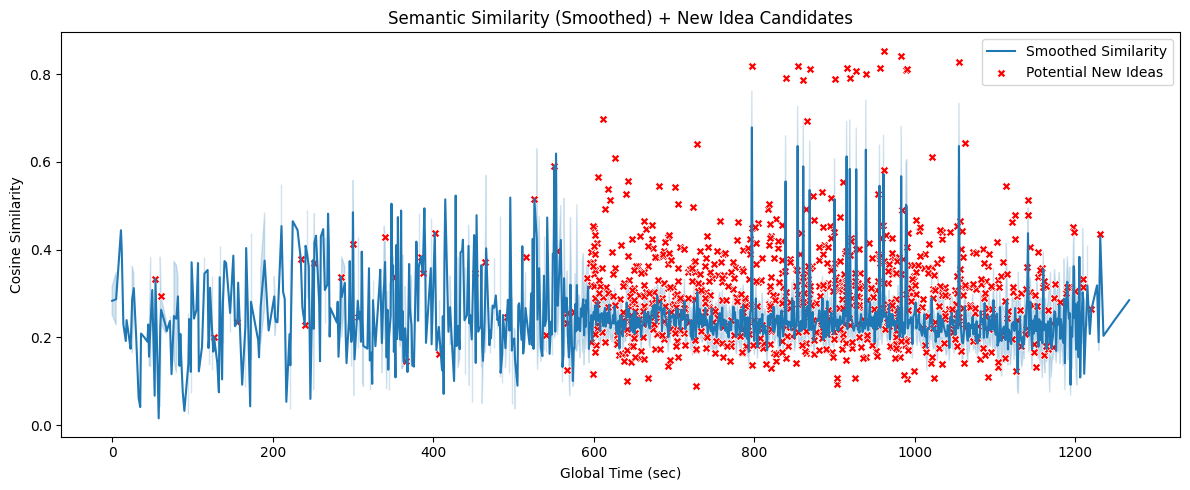

session
2021_09_30_MZT_S7     425
2021_05_20_ABI_S8     326
2021_06_10_SLU_S4     305
2021_05_21_ABI_S5     298
2021_05_21_ABI_S6     288
                     ... 
2021_04_23_MND_S16     52
2021_09_30_MZT_S6      39
2021_04_23_MND_S9      37
2021_04_22_MND_S8      31
2021_04_22_MND_S2       1
Name: count, Length: 82, dtype: int64


In [5]:
import platform
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 1. Detect machine + load correct file
hostname = platform.node()
print(f"👋 Hostname detected: {hostname}")

# Choose correct path based on machine
data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Sanity check
if not data_path.exists():
    raise FileNotFoundError(f"❌ File not found: {data_path.resolve()}")

print(f"✅ Loading from: {data_path}")
df = pd.read_csv(data_path)


# 2. Filter for non-empty transcripts
df = df[df['transcript'].notnull()].reset_index(drop=True)

# 3. Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 4. Compute sentence embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# 5. Cosine similarity between adjacent utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# 6. Semantic shift + smoothing
df['similarity_diff'] = df['cosine_similarity_to_next'].diff()
df['potential_new_idea'] = df['similarity_diff'] < -0.4
df['similarity_smoothed'] = df['cosine_similarity_to_next'].rolling(window=5, min_periods=1).mean()
df['is_expanding'] = df['similarity_smoothed'] > 0.7
df['is_diverging'] = df['similarity_smoothed'] < 0.3

# 7. Plot smoothed similarity with new idea candidates
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['global_timestamp_sec'], y=df['similarity_smoothed'], label="Smoothed Similarity")
sns.scatterplot(x=df[df['potential_new_idea']]['global_timestamp_sec'],
                y=df[df['potential_new_idea']]['similarity_smoothed'],
                color='red', label='Potential New Ideas', marker='X')
plt.title("Semantic Similarity (Smoothed) + New Idea Candidates")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Optional: See session distribution
print(df['session'].value_counts())

# 9. Optional: Export moments
df[df['potential_new_idea']][['session', 'speaker', 'global_timestamp_sec', 'transcript']].to_csv("new_idea_candidates.csv", index=False)


But then, for future note, how can I tell that SBERT is in fact making a difference, even if right now in the ipynb we are just looking at the 'potential new ideas' component code.

Because again, in the final code book, remember, we are using a combination of features to get the convergence/divergence towards a solution in a particular session b/w 7-8 researchers.

Also, remember that these sessions are split into 600 second clips or so so compatible w/ Gemini.

### Looking at one particular session from conference for e.g.

2021_09_30_MZT_S7

(will scale up later if all this works out... somehow)

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📋 Valid sessions with non-null transcript + timestamp:
 global_session
2021_09_30_MZT_S7_MZT    425
2021_05_20_ABI_S8_ABI    326
2021_06_10_SLU_S4_SLU    305
2021_05_21_ABI_S5_ABI    298
2021_05_21_ABI_S6_ABI    288
                        ... 
2021_09_30_MZT_S6_MZT     39
2021_04_23_MND_S9_MND     37
2021_04_22_MND_S8_MND     31
2021_04_23_MND_S4_MND     14
2021_04_22_MND_S2_MND      1
Length: 82, dtype: int64
⚠️  Not enough data in 2021_09_30_MZT_S7. Using fallback session...


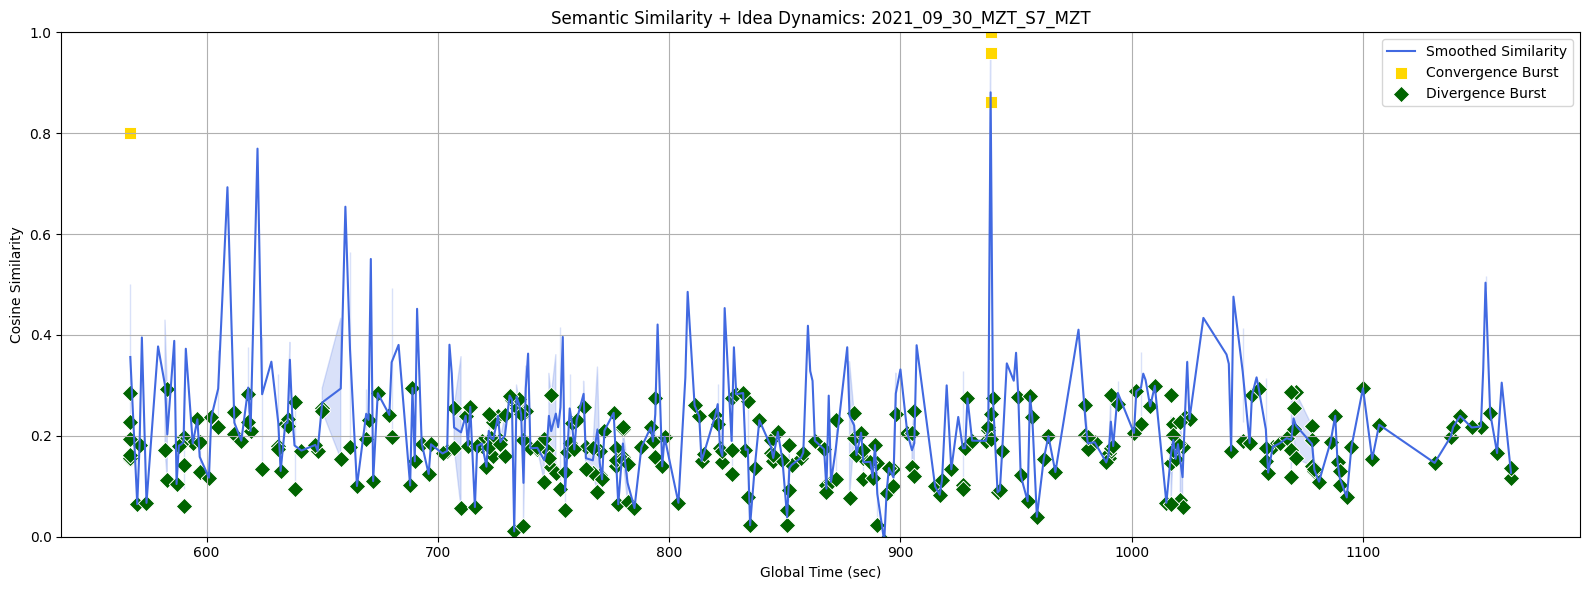

In [6]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Check which sessions have usable transcript + timestamp data
valid_sessions = (
    df[['global_session', 'transcript', 'global_timestamp_sec']]
    .dropna(subset=['transcript', 'global_timestamp_sec'])
    .groupby('global_session')
    .size()
    .sort_values(ascending=False)
)
print("📋 Valid sessions with non-null transcript + timestamp:\n", valid_sessions)

# Select target session
target_session = '2021_09_30_MZT_S7'
df_one = df[df['global_session'] == target_session].copy()
if df_one['transcript'].dropna().shape[0] < 2:
    print(f"⚠️  Not enough data in {target_session}. Using fallback session...")
    target_session = valid_sessions.index[0]
    df_one = df[df['global_session'] == target_session].copy()

# Generate embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute similarity between each utterance and the previous one
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)
df_one['similarity'] = similarities

# Smooth similarity with rolling average
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Identify SBERT new ideas (sharp drops in similarity > 0.4)
df_one['similarity_drop'] = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = df_one['similarity_drop'] < -0.4

# Convergence bursts: 3+ utterances with similarity > 0.75
df_one['in_valid_burst'] = df_one['similarity_smoothed'] > 0.75
df_one['in_valid_burst'] = df_one['in_valid_burst'].astype(int)
df_one['convergence_burst_id'] = (df_one['in_valid_burst'].diff(1) != 0).cumsum()
df_one['in_valid_burst'] = df_one.groupby('convergence_burst_id')['in_valid_burst'].transform(
    lambda x: (x.sum() >= 3) & (x == 1)
)

# Divergence bursts: 3+ utterances with similarity < 0.3
df_one['in_divergence_burst'] = df_one['similarity_smoothed'] < 0.3
df_one['in_divergence_burst'] = df_one['in_divergence_burst'].astype(int)
df_one['divergence_burst_id'] = (df_one['in_divergence_burst'].diff(1) != 0).cumsum()
df_one['in_divergence_burst'] = df_one.groupby('divergence_burst_id')['in_divergence_burst'].transform(
    lambda x: (x.sum() >= 3) & (x == 1)
)

# Add dummy Gemini column if not present
if 'gemini_new_idea' not in df_one.columns:
    df_one['gemini_new_idea'] = False

# Plot
if df_one['global_timestamp_sec'].notnull().sum() >= 2:
    plt.figure(figsize=(16, 6))

    sns.lineplot(
        x=df_one['global_timestamp_sec'],
        y=df_one['similarity_smoothed'],
        label="Smoothed Similarity",
        color='royalblue'
    )

    sns.scatterplot(
        x=df_one[df_one['potential_new_idea']]['global_timestamp_sec'],
        y=df_one[df_one['potential_new_idea']]['similarity_smoothed'],
        color='red', label='SBERT New Ideas', marker='X', s=100
    )

    sns.scatterplot(
        x=df_one[df_one['in_valid_burst']]['global_timestamp_sec'],
        y=df_one[df_one['in_valid_burst']]['similarity_smoothed'],
        color='gold', label='Convergence Burst', marker='s', s=70
    )

    sns.scatterplot(
        x=df_one[df_one['in_divergence_burst']]['global_timestamp_sec'],
        y=df_one[df_one['in_divergence_burst']]['similarity_smoothed'],
        color='darkgreen', label='Divergence Burst', marker='D', s=70
    )

    sns.scatterplot(
        x=df_one[df_one['gemini_new_idea']]['global_timestamp_sec'],
        y=df_one[df_one['gemini_new_idea']]['similarity_smoothed'],
        color='magenta', label='Gemini New Ideas', marker='o', s=70
    )

    plt.title(f"Semantic Similarity + Idea Dynamics: {target_session}")
    plt.xlabel("Global Time (sec)")
    plt.ylabel("Cosine Similarity")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"🚫 No valid global_timestamp_sec values found in {target_session} for plotting.")


#### How Semantic Convergence and Divergence Bursts Are Calculated

The chart above visualizes semantic dynamics across the team meeting session `2021_09_30_MZT_S7`. It blends SBERT-based sentence embeddings with Gemini behavioral annotations to reveal when new ideas emerge, how they are elaborated, and where alignment or divergence happens.

- **Blue Line (Smoothed Similarity)**  
  A rolling average of cosine similarity between adjacent utterances (window = 5), computed from SBERT sentence embeddings. Higher values indicate that utterances are more semantically similar — a proxy for alignment or elaboration.

- **Red X’s (SBERT New Ideas)**  
  Moments of sharp semantic divergence (similarity drops > 0.4 compared to the prior utterance). These are hypothesized new idea moments based on linguistic novelty, even if they aren’t behaviorally marked.

- **Gold Squares (Convergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity > 0.75. These indicate sustained semantic alignment — likely periods of elaboration, agreement, or co-development of an idea.

- **Dark Green Diamonds (Divergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity < 0.3. These may reflect topic shifts, disagreements, or conceptual fragmentation.

- **Magenta Dots (Gemini New Ideas)**  
  Utterances labeled as “new idea” by Gemini’s behavioral coding system — often based on cues like tone, timing, and interaction dynamics.

Together, these signals allow us to track not only *when* a new idea emerges, but *how it flows*, *who aligns with it*, and *whether it leads to convergence or fragmentation*.


**Question:**

But then from the 3+ or the gold squares, does that mean we've converged to a solution that is in sight?

But also noticing for this convergent burst in the graph, it looks to occur at the 75% minute mark? Could they find solution at this point in the meeting?

- Not necessarily. Because remember, teams may peak early, diverge again, and re-converge later?


So then given this pattern of potential peak early, diverge again, and re-converge later, then what is the best move from here?

## Modeling the Convergence Arc Over Time

Trying to see if the convergence spikes tell something about the solutions, then.

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


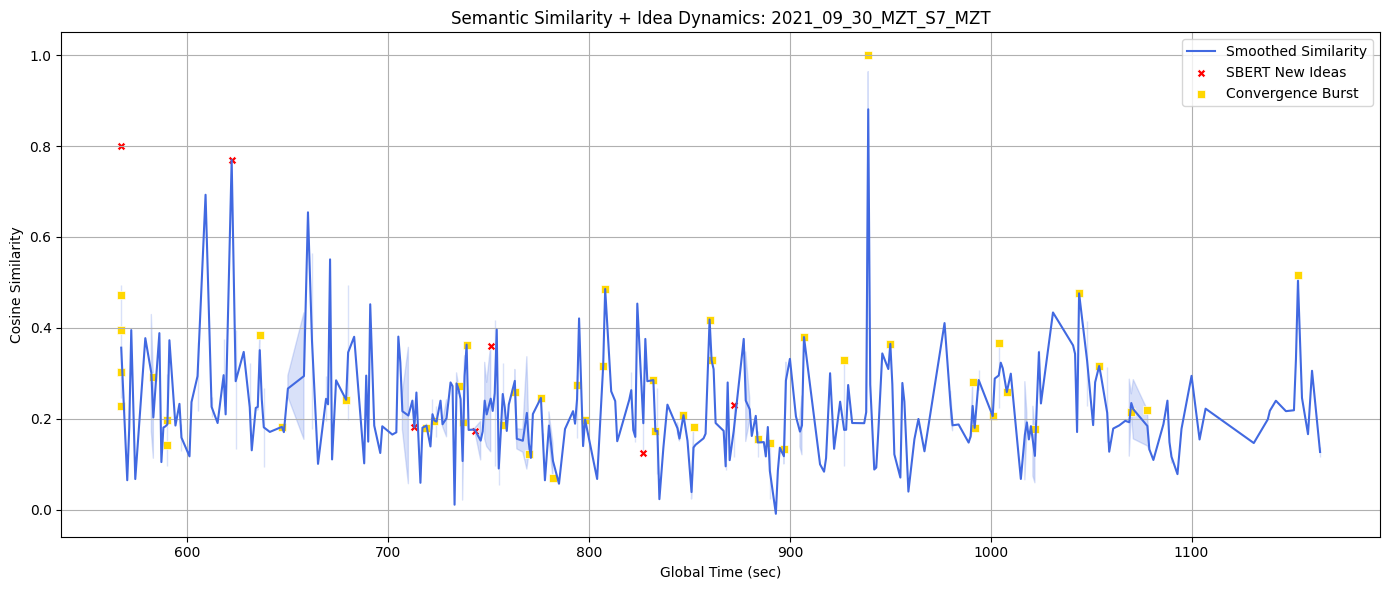

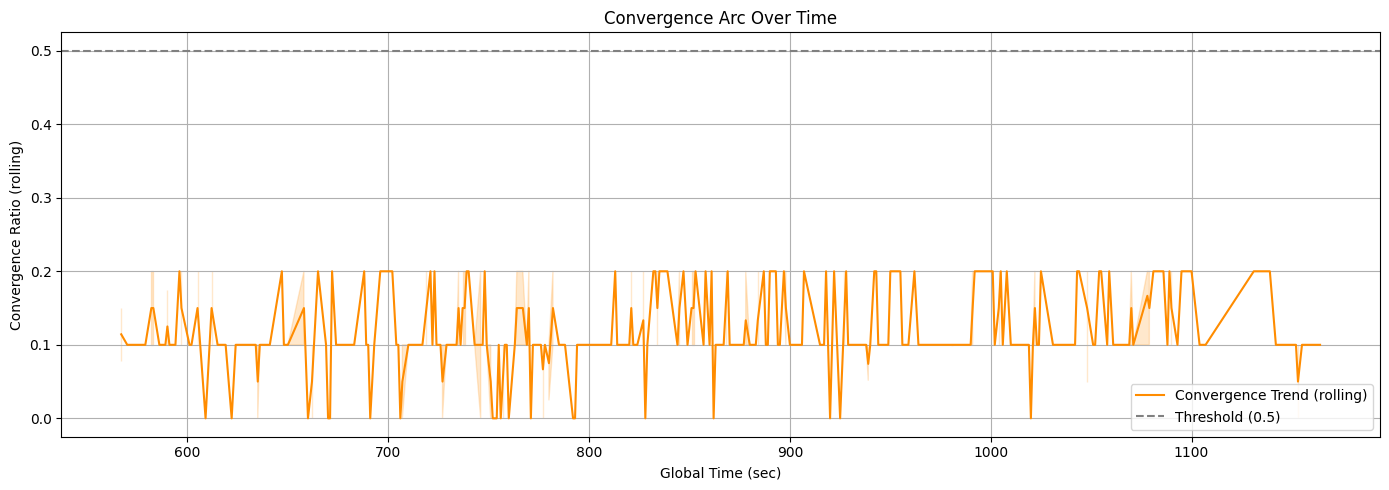

In [7]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Filter a valid session with transcript + timestamp
valid_sessions = df.dropna(subset=['transcript', 'global_timestamp_sec']).groupby('global_session').size()
fallback_session = valid_sessions.idxmax()

df_one = df[df['global_session'] == fallback_session].copy()

# Generate SBERT embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute cosine similarity between adjacent utterances
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)

# Add similarity columns
df_one['similarity'] = similarities
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Define new ideas based on similarity drop
similarity_diffs = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = similarity_diffs < -0.15

# --- 🔶 Placeholder Convergence Burst Detection ---
# Assume local peaks in smoothed similarity indicate convergence bursts
peaks, _ = find_peaks(df_one['similarity_smoothed'].fillna(0), distance=5)
df_one['in_valid_burst'] = False
df_one.loc[df_one.index[peaks], 'in_valid_burst'] = True

# Fill in other optional columns if missing
for col in ['in_divergence_burst', 'gemini_new_idea']:
    if col not in df_one.columns:
        df_one[col] = False

# --- 📈 Plot 1: Semantic Similarity + New Ideas ---
plt.figure(figsize=(14, 6))
sns.lineplot(
    x=df_one['global_timestamp_sec'],
    y=df_one['similarity_smoothed'],
    label="Smoothed Similarity",
    color='royalblue'
)
sns.scatterplot(
    x=df_one[df_one['potential_new_idea']]['global_timestamp_sec'],
    y=df_one[df_one['potential_new_idea']]['similarity_smoothed'],
    color='red', label='SBERT New Ideas', marker='X'
)
sns.scatterplot(
    x=df_one[df_one['in_valid_burst']]['global_timestamp_sec'],
    y=df_one[df_one['in_valid_burst']]['similarity_smoothed'],
    color='gold', label='Convergence Burst', marker='s'
)
plt.title(f"Semantic Similarity + Idea Dynamics: {fallback_session}")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 📈 Plot 2: Convergence Arc Over Time ---
df_one['running_convergence_ratio'] = df_one['in_valid_burst'].rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(14, 5))
sns.lineplot(
    x=df_one['global_timestamp_sec'],
    y=df_one['running_convergence_ratio'],
    color='darkorange',
    label='Convergence Trend (rolling)'
)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')
plt.title("Convergence Arc Over Time")
plt.xlabel("Global Time (sec)")
plt.ylabel("Convergence Ratio (rolling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Tracing Idea Dynamics: Who Introduces and Who Expands?

In [8]:
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parameters
window = 5  # How many utterances after a new idea to consider as follow-up

# Identify potential new idea rows
idea_rows = df_one[df_one['potential_new_idea']].index.tolist()
print(f"🔍 Found {len(idea_rows)} potential new ideas")

idea_expansion_events = []

for idea_idx in idea_rows:
    idea_text = df_one.loc[idea_idx, 'transcript']
    if pd.isna(idea_text) or str(idea_text).strip() == "":
        continue  # skip invalid idea

    try:
        idea_embed = model.encode(idea_text, convert_to_tensor=True)
    except Exception as e:
        print(f"⚠️ Skipping idea at index {idea_idx}: {e}")
        continue

    for offset in range(1, window + 1):
        follow_idx = idea_idx + offset
        if follow_idx >= len(df_one):
            break

        follow_text = df_one.loc[follow_idx, 'transcript']
        if pd.isna(follow_text) or str(follow_text).strip() == "":
            continue  # skip empty follow-up

        try:
            follow_embed = model.encode(follow_text, convert_to_tensor=True)
            similarity = util.cos_sim(idea_embed, follow_embed).item()
        except Exception as e:
            print(f"⚠️ Skipping follow-up at index {follow_idx}: {e}")
            continue

        idea_expansion_events.append({
            'idea_idx': idea_idx,
            'idea_time': df_one.loc[idea_idx, 'global_timestamp_sec'],
            'idea_speaker': df_one.loc[idea_idx, 'speaker'],
            'followup_idx': follow_idx,
            'followup_time': df_one.loc[follow_idx, 'global_timestamp_sec'],
            'followup_speaker': df_one.loc[follow_idx, 'speaker'],
            'semantic_similarity': similarity,
        })

# === Analyze and Plot ===
idea_expansion_df = pd.DataFrame(idea_expansion_events)
print(f"✅ Expansion event rows: {idea_expansion_df.shape[0]}")

if not idea_expansion_df.empty and 'semantic_similarity' in idea_expansion_df.columns:
    high_sim_followups = idea_expansion_df[idea_expansion_df['semantic_similarity'] > 0.6]
    print(f"✅ Strong expansions (similarity > 0.6): {len(high_sim_followups)}")

    if not high_sim_followups.empty:
        print("🔍 Who tends to expand on ideas?")
        print(high_sim_followups.groupby('followup_speaker').size().sort_values(ascending=False))

        print("\n🔍 Who expands on whose ideas?")
        print(high_sim_followups.groupby(['idea_speaker', 'followup_speaker']).size().sort_values(ascending=False))

        plt.figure(figsize=(14, 5))
        sns.scatterplot(
            data=high_sim_followups,
            x='followup_time',
            y='semantic_similarity',
            hue='followup_speaker',
            palette='Dark2',
            s=120,
            edgecolor='black',
            linewidth=0.6,
            alpha=0.9
        )
        plt.title("Idea Expansion Events Over Time")
        plt.xlabel("Global Time (sec)")
        plt.ylabel("Semantic Similarity to Original Idea")
        plt.grid(True)
        plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("📭 No strong idea expansions (sim > 0.6).")
else:
    print("⚠️ No expansion data or 'semantic_similarity' column missing.")


🔍 Found 7 potential new ideas
✅ Expansion event rows: 0
⚠️ No expansion data or 'semantic_similarity' column missing.


In [9]:
df_one.loc[df_one['potential_new_idea'], ['transcript', 'speaker', 'global_timestamp_sec']].reset_index()

for idx in df_one[df_one['potential_new_idea']].index:
    print(f"\n🧠 New idea @ {idx} | Speaker: {df_one.loc[idx, 'speaker']}")
    print("Idea:", df_one.loc[idx, 'transcript'])

    for i in range(1, 6):
        follow_idx = idx + i
        if follow_idx >= len(df_one):
            break
        print(f"  → Follow-up {i} [{df_one.loc[follow_idx, 'speaker']}]: {df_one.loc[follow_idx, 'transcript']}")



🧠 New idea @ 15567 | Speaker: Linda Detwiler
Idea: Um, I think what we'll do is we'll start with the um I'll put up here I'll share my screen and we'll put the conversation or the um topics, you know, that they suggest or at least for uh starting and then we'll have you take about a minute and write the questions that you think are should be answered in regards to this evolution and coevolution. And then when we come back, I'll have you go around and kind of say who you are and and give a little bit about your background. So I'm going to just share the screen and and put this up real quick.

🧠 New idea @ 15618 | Speaker: Hannah Frank
Idea: I go out, I catch bats, I take their saliva and then I do these PCRs for various infections. Um trying to understand what's out there. And something that I always think about is like I can get, you know, data on the infections, I can get data on, you know, immune parameters and stuff and but like what does that tell us? Like if you have a highly def

So then from here could do the following (likely listed in personal priority):

1. Visual Convergence + Expansion Together 

Overlay convergence arcs + idea expansions in one plot. To see when expansions cluster inside convergence arcs, and who is contributing

2. Speaker Role Analysis

Could do a speaker taxonomy role 
(e.g.: new idea generator, expander, reframer, silent partner, simple counts - also work).
- Because then: some *very* future step would be to track individual people across different sessions / conferences (if they somehow go to multiple conference; but this far is unlikely).

3. Network Graph of Idea -- **this idea doesn't work.**

Visualizing the speakers as nodes - giving semantic interaction network over time.

Remember there's only 4-7 scientists per session.

4. Temporal Distance of Expansion

How long after a new idea do expansions happen? Are they immediate (w/in 5 utterances) or delayed (15+ utterances).
This could also tell about discussion structure.

## (1) When do expansions happen - do they align with convergence?

In [10]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Filter to rows with non-null transcript and timestamp
valid_rows = df[df['transcript'].notna() & df['global_timestamp_sec'].notna()]

# Identify sessions with valid data
valid_sessions = valid_rows['global_session'].value_counts()
print("📋 Valid sessions with non-null transcript + timestamp:\n", valid_sessions)

# Choose a fallback session (first with enough rows)
target_session = valid_sessions.index[0]
df_one = df[df['global_session'] == target_session].copy()

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate SBERT embeddings
embeddings = model.encode(df_one['transcript'].astype(str).tolist(), convert_to_tensor=True)

# Compute similarity to previous utterance
similarities = [1.0]
for i in range(1, len(embeddings)):
    sim = util.cos_sim(embeddings[i], embeddings[i - 1]).item()
    similarities.append(sim)
df_one['similarity'] = similarities
df_one['similarity_smoothed'] = df_one['similarity'].rolling(window=5, min_periods=1).mean()

# Detect potential new ideas
similarity_diffs = df_one['similarity_smoothed'].diff().fillna(0)
df_one['potential_new_idea'] = similarity_diffs < -0.15
print(f"🧠 Found {df_one['potential_new_idea'].sum()} potential new ideas")

# Create expansion events
window = 5
idea_rows = df_one[df_one['potential_new_idea']].index.tolist()
idea_expansion_events = []

for idea_idx in idea_rows:
    idea_text = df_one.loc[idea_idx, 'transcript']
    idea_embed = model.encode(idea_text, convert_to_tensor=True)

    for offset in range(1, window + 1):
        follow_idx = idea_idx + offset
        if follow_idx >= len(df_one):
            break
        follow_text = df_one.loc[follow_idx, 'transcript']
        follow_embed = model.encode(follow_text, convert_to_tensor=True)

        similarity = util.cos_sim(idea_embed, follow_embed).item()

        idea_expansion_events.append({
            'idea_idx': idea_idx,
            'idea_time': df_one.loc[idea_idx, 'global_timestamp_sec'],
            'idea_speaker': df_one.loc[idea_idx, 'speaker'],
            'followup_idx': follow_idx,
            'followup_time': df_one.loc[follow_idx, 'global_timestamp_sec'],
            'followup_speaker': df_one.loc[follow_idx, 'speaker'],
            'semantic_similarity': similarity,
        })

# Convert to DataFrame
idea_expansion_df = pd.DataFrame(idea_expansion_events)
print(f"✅ Expansion event rows: {idea_expansion_df.shape[0]}")

# Filter for strong expansions
if 'semantic_similarity' in idea_expansion_df.columns:
    high_sim_followups = idea_expansion_df[idea_expansion_df['semantic_similarity'] > 0.6]
    print(f"✅ Strong expansions (similarity > 0.6): {len(high_sim_followups)}")
else:
    high_sim_followups = pd.DataFrame()
    print("⚠️ 'semantic_similarity' column not found in expansion DataFrame.")

# Visualization (only if data exists)
if not high_sim_followups.empty:
    plt.figure(figsize=(14, 5))
    sns.scatterplot(
        data=high_sim_followups,
        x='followup_time',
        y='semantic_similarity',
        hue='followup_speaker',
        palette='Dark2',
        s=120,
        edgecolor='black',
        linewidth=0.6,
        alpha=0.9
    )
    plt.axhline(y=0.6, color='gray', linestyle='--', label='Similarity Threshold')
    plt.title(f"Idea Expansion Events: {target_session}")
    plt.xlabel("Global Time (sec)")
    plt.ylabel("Semantic Similarity to Original Idea")
    plt.grid(True)
    plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No high_sim_followups data available. Skipping plot.")


📋 Valid sessions with non-null transcript + timestamp:
 global_session
2021_09_30_MZT_S7_MZT    425
2021_05_20_ABI_S8_ABI    326
2021_06_10_SLU_S4_SLU    305
2021_05_21_ABI_S5_ABI    298
2021_05_21_ABI_S6_ABI    288
                        ... 
2021_09_30_MZT_S6_MZT     39
2021_04_23_MND_S9_MND     37
2021_04_22_MND_S8_MND     31
2021_04_23_MND_S4_MND     14
2021_04_22_MND_S2_MND      1
Name: count, Length: 82, dtype: int64


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🧠 Found 7 potential new ideas
✅ Expansion event rows: 0
⚠️ 'semantic_similarity' column not found in expansion DataFrame.
⚠️ No high_sim_followups data available. Skipping plot.


## visual convergence + expansion

In [11]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Recompute embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# Compute cosine similarity between consecutive utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# ---- ADDITIONAL PROCESSING FOR CONVERGENCE + EXPANSION ---- #

# (1) Flag expansions based on Gemini annotations
# Assuming has_new_idea and has_explanation columns exist (bool or 0/1)
df['is_expansion'] = df['has_new_idea'].fillna(False) | df['has_explanation'].fillna(False)

# (2) Flag convergence arcs using cosine similarity threshold
CONVERGENCE_THRESHOLD = 0.6  # tweakable
df['is_converging'] = df['cosine_similarity_to_next'] > CONVERGENCE_THRESHOLD

# Optional: Confirm counts
print(f"Total utterances: {len(df)}")
print(f"Expansions flagged: {df['is_expansion'].sum()}")
print(f"Convergence arcs flagged: {df['is_converging'].sum()}")



/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Total utterances: 16467
Expansions flagged: 3804
Convergence arcs flagged: 1267


## (2) Speaker Role Analysis

                speaker  total_utterances  new_ideas  expansions  idea_ratio  \
320    Lisa Kaltenegger               257         29          23    0.112840   
72           Brad Smith               220         16          16    0.072727   
75          Brian Pogue               206          8          19    0.038835   
384      Niki Parenteau               193          2          19    0.010363   
131    Dimitar Sasselov               191         11          24    0.057592   
..                  ...               ...        ...         ...         ...   
174            Haike Qi                 1          0           0    0.000000   
394            Paul Hsu                 1          0           0    0.000000   
186                 Jae                 1          0           0    0.000000   
192        Jamie Bender                 1          0           0    0.000000   
369  Michael D Cullinan                 1          0           0    0.000000   

     expansion_ratio   role  
320      

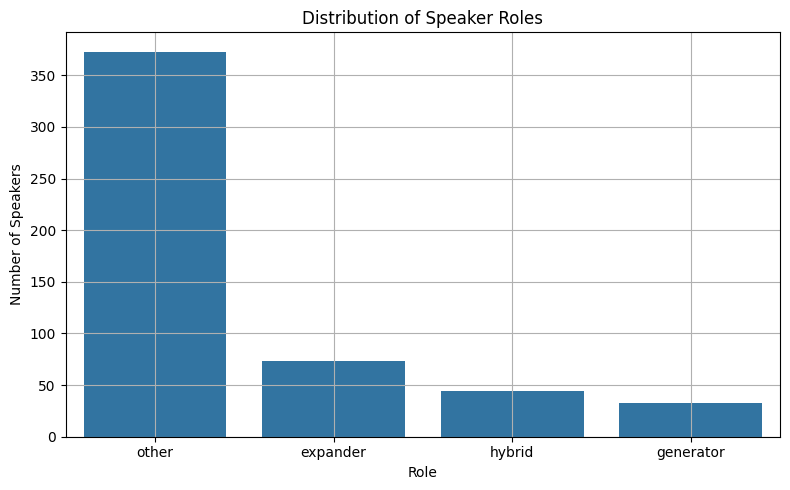

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Count speaker stats ---
speaker_stats = df.groupby('speaker').agg(
    total_utterances=('transcript', 'count'),
    new_ideas=('has_new_idea', 'sum'),
    expansions=('has_explanation', 'sum')
).reset_index()

# --- Add ratio columns ---
speaker_stats['idea_ratio'] = speaker_stats['new_ideas'] / speaker_stats['total_utterances']
speaker_stats['expansion_ratio'] = speaker_stats['expansions'] / speaker_stats['total_utterances']

# --- Classify speaker roles ---
def classify_role(row):
    if row['idea_ratio'] > 0.3 and row['expansion_ratio'] < 0.2:
        return "generator"
    elif row['expansion_ratio'] > 0.3 and row['idea_ratio'] < 0.2:
        return "expander"
    elif row['idea_ratio'] > 0.2 and row['expansion_ratio'] > 0.2:
        return "hybrid"
    else:
        return "other"

speaker_stats['role'] = speaker_stats.apply(classify_role, axis=1)

# --- Optional: view the speaker summary table ---
print(speaker_stats.sort_values(by='total_utterances', ascending=False))

# --- Now plot role distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(data=speaker_stats, x='role', order=speaker_stats['role'].value_counts().index)
plt.title("Distribution of Speaker Roles")
plt.xlabel("Role")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.tight_layout()
plt.show()


But with all of this:

- I am able to figure out the points of convergences (and by contrast, divergences).


BUT ---- THIS IS STILL THE ISSUE THAT I AM HAVING AT THIS POINT IN THE IPYNB

- do these "major points of convergences" actually lead to a point of solution. 

Take note that - in fact - not all convergences are created equal.

- AND, can this be backed by the transcript (or something similar - would multiple metrics have to be use.)?



So, given all this - at this point in the ipynb:

Should I send my notebook to Evey with all of the progress.

OR

I can look up another piece of literature on "How do we know if convergence leads to a meaningful outcome or solution?"

**I can try searching up these paper topics:**

"Decision-making in team science meetings"

"Language markers of scientific insight"

"Convergence and knowledge creation in collaborative work"

"Discourse patterns in consensus-building"

"Linguistic indicators of innovation in teams"

Convergence can happen *before* and *after* collaborative learning sessions.

B/c the different types of convergence is:

1. Stated convergence

2. Inferred convergence

(more information in the Google Docs)

## Speaker Contributions and Convergence Dynamics

In [13]:
import numpy as np
import pandas as pd

# 0) Ensure sorted & required cols
if 'global_timestamp_sec' not in df_one.columns:
    if 'timestamp_sec' in df_one.columns:
        df_one['global_timestamp_sec'] = df_one['timestamp_sec'].astype(float)
    else:
        raise ValueError("Need a time column: add 'global_timestamp_sec' or 'timestamp_sec'.")

df_one = df_one.sort_values('global_timestamp_sec').reset_index(drop=True)
df_one['transcript'] = df_one['transcript'].fillna("").astype(str)

# 1) Build windowed texts (k = 3 by default)
WINDOW_SIZE_UTTS = 3
half = WINDOW_SIZE_UTTS // 2
texts = df_one['transcript'].tolist()
win_texts = []
for i in range(len(texts)):
    s = max(0, i-half)
    e = min(len(texts), i+half+1)
    win_texts.append(" ".join(texts[s:e]))

# 2) Get embeddings (choose ONE of the two blocks)

## 2A) REAL SBERT (if you have sentence_transformers installed)
# from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('all-MiniLM-L6-v2')
# E = model.encode(win_texts, show_progress_bar=False, normalize_embeddings=True)

## 2B) TEMPORARY fallback (lets you test the flow w/out SBERT)
# *Replace later with 2A*
E = np.array([[len(t) % 17, len(t) % 23, len(t) % 29] for t in win_texts], dtype=float)
E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-8)

# 3) Adjacent cosine similarity → sim_adj
sim = []
for i in range(len(E)):
    j = i+1 if i+1 < len(E) else i
    # cosine since rows are normalized
    sim.append(float(np.dot(E[i], E[j])))
df_one['sim_adj'] = np.array(sim, dtype=float)

# 4) Detect bursts from sim_adj
def detect_bursts(sim, mode="zscore", z_above=1.0, top_p=0.10, min_len=4, min_gap=3):
    x = np.asarray(sim, dtype=float)
    if mode == "zscore":
        mu, sd = np.nanmean(x), np.nanstd(x) + 1e-8
        mask = (x - mu) / sd >= z_above
    elif mode == "percentile":
        thr = np.nanpercentile(x, 100*(1-top_p))
        mask = x >= thr
    else:
        raise ValueError("mode must be 'zscore' or 'percentile'.")

    # mask → spans
    spans, i = [], 0
    while i < len(mask):
        if mask[i]:
            j = i
            while j+1 < len(mask) and mask[j+1]:
                j += 1
            if (j - i + 1) >= min_len:
                spans.append((i, j))
            i = j + 1
        else:
            i += 1

    # merge spans that are too close
    merged = []
    for s in spans:
        if not merged:
            merged.append(s)
        else:
            p0, p1 = merged[-1]
            if s[0] - p1 - 1 <= min_gap:
                merged[-1] = (p0, s[1])
            else:
                merged.append(s)
    return merged

# choose your params
arcs = detect_bursts(
    df_one['sim_adj'].to_numpy(),
    mode="zscore",  # or "percentile"
    z_above=1.0,
    top_p=0.10,
    min_len=4,
    min_gap=3
)

# 5) Build in_valid_burst mask from arcs for downstream code
mask = np.zeros(len(df_one), dtype=bool)
for (s, e) in arcs:
    s = max(0, int(s)); e = min(len(df_one)-1, int(e))
    mask[s:e+1] = True
df_one['in_valid_burst'] = mask


In [15]:
import numpy as np
import pandas as pd

# --- 1) Ensure required columns exist (or create safe defaults) ---
def ensure_flags_roles_and_bursts(df, arcs=None):
    d = df.copy()

    # Time column sanity
    if 'global_timestamp_sec' not in d.columns and 'timestamp_sec' in d.columns:
        d['global_timestamp_sec'] = pd.to_numeric(d['timestamp_sec'], errors='coerce')

    # has_new_idea
    if 'has_new_idea' not in d.columns:
        if 'annotations' in d.columns:
            d['has_new_idea'] = d['annotations'].astype(str).str.contains(r'\b(has_)?new_idea\b', case=False).astype(int)
        else:
            d['has_new_idea'] = 0
    else:
        d['has_new_idea'] = pd.to_numeric(d['has_new_idea'], errors='coerce').fillna(0).astype(int)

    # has_explanation
    if 'has_explanation' not in d.columns:
        if 'annotations' in d.columns:
            d['has_explanation'] = d['annotations'].astype(str).str.contains(r'\b(has_)?explanation\b', case=False).astype(int)
        else:
            d['has_explanation'] = 0
    else:
        d['has_explanation'] = pd.to_numeric(d['has_explanation'], errors='coerce').fillna(0).astype(int)

    # role (generator / expander / hybrid / other)
    if 'role' not in d.columns:
        stats = (
            d.groupby('speaker', dropna=False)
             .agg(total=('transcript','count'),
                  new_ideas=('has_new_idea','sum'),
                  expansions=('has_explanation','sum'))
             .reset_index()
        )
        stats['idea_ratio'] = stats['new_ideas'] / stats['total'].replace(0, np.nan)
        stats['expansion_ratio'] = stats['expansions'] / stats['total'].replace(0, np.nan)
        stats = stats.fillna(0.0)

        def classify(ir, er):
            if ir > 0.30 and er < 0.20: return 'generator'
            if er > 0.30 and ir < 0.20: return 'expander'
            if ir > 0.20 and er > 0.20: return 'hybrid'
            return 'other'

        stats['role'] = [classify(ir, er) for ir, er in zip(stats['idea_ratio'], stats['expansion_ratio'])]
        d = d.merge(stats[['speaker','role']], on='speaker', how='left')

    # in_valid_burst (boolean mask): from arcs if provided; otherwise False
    if 'in_valid_burst' not in d.columns:
        if arcs and isinstance(arcs, (list, tuple)) and len(arcs) > 0:
            mask = np.zeros(len(d), dtype=bool)
            for s, e in arcs:
                s = max(0, int(s)); e = min(len(d) - 1, int(e))
                mask[s:e+1] = True
            d['in_valid_burst'] = mask
        else:
            d['in_valid_burst'] = False

    # type hygiene
    d['role'] = d['role'].fillna('other')
    d['speaker'] = d['speaker'].astype(str)
    d = d.dropna(subset=['global_timestamp_sec'])
    d['global_timestamp_sec'] = pd.to_numeric(d['global_timestamp_sec'], errors='coerce')

    return d

df_one = ensure_flags_roles_and_bursts(df_one)


### Checking Convergence Burst

In [16]:
import numpy as np
import pandas as pd

def build_burst_df(df):
    # guards
    if 'in_valid_burst' not in df.columns:
        raise ValueError("Missing df['in_valid_burst']. Create arcs/mask first.")
    if 'global_timestamp_sec' not in df.columns:
        if 'timestamp_sec' in df.columns:
            df = df.copy()
            df['global_timestamp_sec'] = df['timestamp_sec'].astype(float)
        else:
            raise ValueError("Need a time column: 'global_timestamp_sec' or 'timestamp_sec'.")

    # assign burst ids only where mask is True
    mask = df['in_valid_burst'].astype(bool)
    burst_starts = (mask & ~mask.shift(fill_value=False)).cumsum()
    df2 = df.copy()
    df2['burst_id'] = np.where(mask, burst_starts, np.nan)

    groups = df2[df2['in_valid_burst']].groupby('burst_id', dropna=True)

    rows = []
    for i, (bid, g) in enumerate(groups):
        start = float(g['global_timestamp_sec'].min())
        end   = float(g['global_timestamp_sec'].max())
        role_mode = g['role'].mode() if 'role' in g.columns else pd.Series(dtype=object)
        speaker_mode = g['speaker'].mode() if 'speaker' in g.columns else pd.Series(dtype=object)

        rows.append({
            'burst_id': int(i),
            'start_sec': start,
            'end_sec': end,
            'duration_sec': end - start,
            'utterance_count': int(len(g)),
            'speaker_count': int(g['speaker'].nunique(dropna=False)) if 'speaker' in g.columns else None,
            'top_speaker': speaker_mode.iloc[0] if not speaker_mode.empty else None,
            'dominant_role': role_mode.iloc[0] if not role_mode.empty else None,
            'new_idea_count': int(g.get('has_new_idea', pd.Series([0]*len(g))).sum()),
            'explanation_count': int(g.get('has_explanation', pd.Series([0]*len(g))).sum())
        })
    return pd.DataFrame(rows)

# Build if needed
if 'burst_df' not in locals():
    burst_df = build_burst_df(df_one)

# Handle no-burst case
if burst_df.empty:
    print("No bursts detected — try lowering your threshold (e.g., Z_ABOVE=0.5) or using percentile mode (TOP_P=0.2).")
else:
    burst_df = burst_df.sort_values("start_sec").reset_index(drop=True)
    burst_index = 0  # or pick another
    display(burst_df.head())


,burst_id,start_sec,end_sec,duration_sec,utterance_count,speaker_count,top_speaker,dominant_role,new_idea_count,explanation_count
0,0,939.0,939.0,0.0,24,1,Lauren Charles,other,0,0


,arc,utt_start,utt_end,start_sec,end_sec,duration_s,n_utts,speakers,mean_sim,duration_est_s,pos_%
0,1,52,52,604.000000,604.000000,0.000000,1,1,0.923462,1.3,49.1
1,2,54,56,604.666667,605.500000,0.833333,3,3,0.950908,3.9,49.2
2,3,76,79,624.000000,626.333333,2.333333,4,4,0.977166,5.2,50.9
3,4,93,96,636.000000,637.000000,1.000000,4,4,0.919867,5.2,51.7
4,5,112,112,645.000000,645.000000,0.000000,1,1,0.997214,1.3,52.4
5,6,114,117,647.000000,647.600000,0.600000,4,4,0.964224,5.2,52.6
6,7,125,128,650.000000,650.500000,0.500000,4,4,0.945634,5.2,52.8
7,8,153,161,663.800000,668.500000,4.700000,9,9,0.891866,11.8,54.3
8,9,192,195,688.333333,689.500000,1.166667,4,4,0.955735,5.2,56.0
9,10,279,281,741.000000,741.666667,0.666667,3,3,0.947542,3.9,60.2


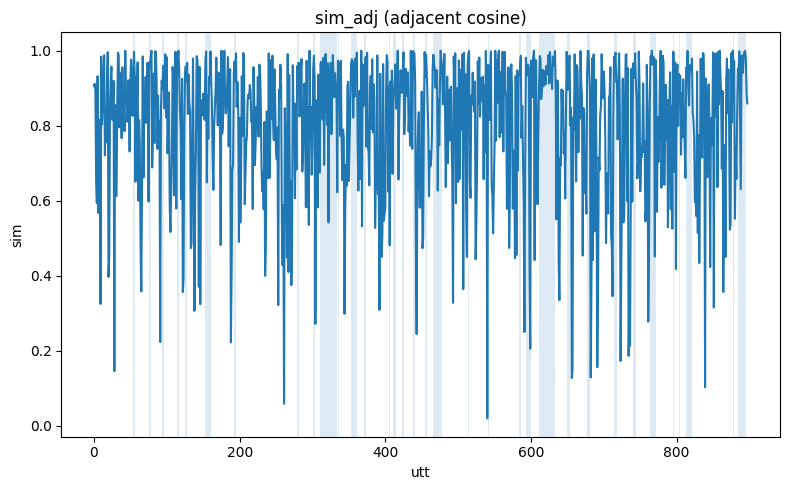

df_converged ready: 212 rows


In [28]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Preserve original order so within-second ranking is stable
df_one = df_one.copy()
if 'utt_idx' not in df_one.columns:
    df_one['utt_idx'] = np.arange(len(df_one))  # original sequence

df_one['global_timestamp_sec'] = pd.to_numeric(df_one['global_timestamp_sec'], errors='coerce')
df_one = (
    df_one.dropna(subset=['global_timestamp_sec'])
          .sort_values(['global_timestamp_sec', 'utt_idx'])
          .reset_index(drop=True)
)

# 1) Rebuild sub-second time that is guaranteed to be nondecreasing with index
counts = df_one['global_timestamp_sec'].map(df_one['global_timestamp_sec'].value_counts())
ranks  = df_one.groupby('global_timestamp_sec').cumcount()
df_one['time_s'] = df_one['global_timestamp_sec'] + ranks / counts

# 2) Build arcs from mask, or sanitize any existing arcs to current index range
def spans_from_mask(mask: np.ndarray):
    spans, i = [], 0
    while i < len(mask):
        if mask[i]:
            j = i
            while j + 1 < len(mask) and mask[j + 1]:
                j += 1
            spans.append((i, j)); i = j + 1
        else:
            i += 1
    return spans

N = len(df_one)
if 'in_valid_burst' in df_one.columns:
    arcs = spans_from_mask(df_one['in_valid_burst'].astype(bool).to_numpy())
elif 'arcs' in locals() and isinstance(arcs, (list, tuple)):
    arcs = [(max(0, min(int(s), N-1)), max(0, min(int(e), N-1))) for s, e in arcs if 0 <= s <= e]
else:
    arcs = []  # no bursts available yet

# 3) Summarize (use iloc + clamp duration >= 0)
rows = []
for k, (s, e) in enumerate(arcs, start=1):
    t0, t1 = float(df_one.iloc[s]['time_s']), float(df_one.iloc[e]['time_s'])
    dur = max(0.0, t1 - t0)  # guard against rare ordering glitches
    rows.append(dict(
        arc=k, utt_start=s, utt_end=e,
        start_sec=t0, end_sec=t1, duration_s=dur,
        n_utts=int(e - s + 1),
        speakers=int(df_one.iloc[s:e+1]['speaker'].nunique()) if 'speaker' in df_one else None,
        mean_sim=float(df_one.iloc[s:e+1]['sim_adj'].mean()) if 'sim_adj' in df_one else None
    ))

burst_df = pd.DataFrame(rows).sort_values('start_sec').reset_index(drop=True)

# human-ish duration estimate from pacing
if not df_one.empty and not burst_df.empty:
    meeting_span_s = float(df_one['global_timestamp_sec'].max() - df_one['global_timestamp_sec'].min())
    sec_per_utt = meeting_span_s / max(1, len(df_one) - 1)
    burst_df['duration_est_s'] = (burst_df['n_utts'] * sec_per_utt).round(1)
    burst_df['pos_%'] = ((burst_df['end_sec'] / df_one['time_s'].max()) * 100).round(1)

display(burst_df)

# 4) Plot sim with shaded bursts
sim = pd.to_numeric(df_one.get('sim_adj'), errors='coerce').fillna(0).to_numpy()
plt.figure(figsize=(8, 5))
plt.plot(sim, linewidth=1.5)
for s, e in arcs:
    plt.axvspan(s, e, alpha=0.15)
plt.title("sim_adj (adjacent cosine)")
plt.xlabel("utt"); plt.ylabel("sim")
plt.tight_layout(); plt.show()

# 5) df_converged for downstream timelines
if {'in_valid_burst','burst_id'}.issubset(df_one.columns):
    df_converged = (df_one[df_one['in_valid_burst']].copy()
                    .assign(timestamp=lambda d: d['time_s'],
                            idea_id=lambda d: d['burst_id']))
    print(f"df_converged ready: {len(df_converged)} rows")


In [29]:
print("rows:", len(df_one),
      "unique_secs:", df_one['global_timestamp_sec'].nunique(),
      "max rows per second:", df_one['global_timestamp_sec'].value_counts().max())


rows: 898 unique_secs: 478 max rows per second: 8


## Visualize Idea Convergence Over Time

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/1638626066.py:47: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


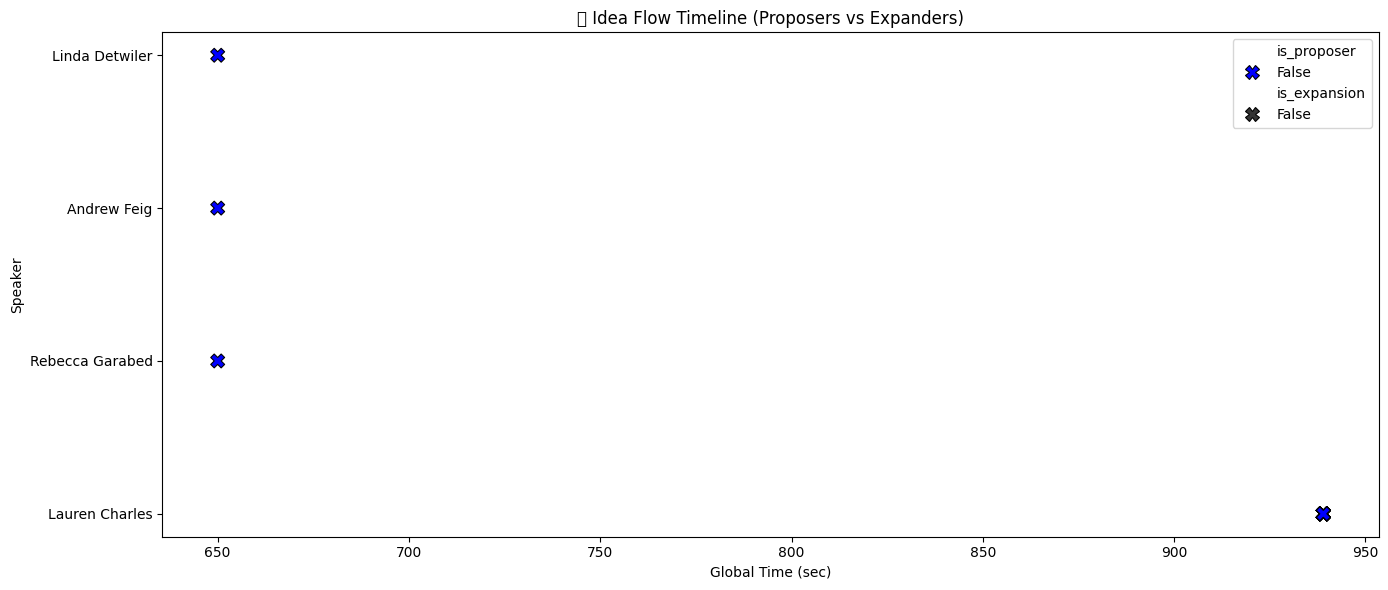

In [21]:
import pandas as pd

# Build a converged-utterances dataframe with the exact columns your plot expects
# Uses utterance-level df_one and your in-burst mask
if 'in_valid_burst' not in df_one.columns:
    raise ValueError("Missing df_one['in_valid_burst']. Make sure you've created bursts/mask.")

df_converged = (
    df_one[df_one['in_valid_burst']].copy()
    .assign(
        # x-axis
        timestamp=lambda d: (
            d['global_timestamp_sec']
            if 'global_timestamp_sec' in d.columns else d['timestamp_sec']
        ),
        # y-axis
        speaker=lambda d: d['speaker'].astype(str),

        # hue/style booleans (tweak logic if needed)
        is_proposer=lambda d: (d.get('role', '').astype(str) == 'generator'),
        is_expansion=lambda d: (pd.to_numeric(d.get('has_explanation', 0), errors='coerce').fillna(0).astype(int) == 1),
    )
)

# Guard: empty frame means no points to plot
if df_converged.empty:
    print("No converged utterances to plot (0 rows). Try relaxing thresholds (e.g., Z_ABOVE=0.5 or TOP_P=0.25).")
else:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 6))
    sns.scatterplot(
        data=df_converged,
        x='timestamp',
        y='speaker',
        hue='is_proposer',
        style='is_expansion',
        palette={True: 'red', False: 'blue'},
        markers={True: 'o', False: 'X'},
        s=100,
        edgecolor='black'
    )
    plt.title("🧭 Idea Flow Timeline (Proposers vs Expanders)")
    plt.xlabel("Global Time (sec)")
    plt.ylabel("Speaker")
    plt.tight_layout()
    plt.show()


## Real-Time Idea Convergence Trajectory Estimation

In [22]:
# --- Imports ---
import numpy as np
import pandas as pd

# --- 0) Load + sort ---
df_one = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/new_idea_candidates.csv").copy()
df_one = df_one.sort_values("global_timestamp_sec").reset_index(drop=True)
df_one["transcript"] = df_one["transcript"].fillna("").astype(str)

# --- 1) Windowed texts (k=3) ---
WINDOW_SIZE_UTTS = 3
half = WINDOW_SIZE_UTTS // 2
texts = df_one["transcript"].tolist()
win_texts = [" ".join(texts[max(0, i-half):min(len(texts), i+half+1)]) for i in range(len(texts))]

# --- 2) Embeddings ---
# Swap this block with SBERT when your env is ready:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("all-MiniLM-L6-v2")
# E = model.encode(win_texts, show_progress_bar=False, normalize_embeddings=True)

# Temporary lightweight placeholder (so the rest of the pipeline runs)
E = np.array([[len(t) % 17, len(t) % 23, len(t) % 29] for t in win_texts], dtype=float)
E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-8)  # L2-normalize rows

# --- 3) Adjacent cosine similarity -> sim_adj ---
sim = []
for i in range(len(E)):
    j = i + 1 if i + 1 < len(E) else i
    sim.append(float(np.dot(E[i], E[j])))  # rows normalized => cosine
df_one["sim_adj"] = np.array(sim, dtype=float)

# --- 4) Detect bursts (tune these if you get 0 bursts) ---
def detect_bursts(sim, mode="zscore", z_above=0.5, top_p=0.25, min_len=3, min_gap=3):
    x = np.asarray(sim, dtype=float)
    if mode == "zscore":
        mu, sd = np.nanmean(x), np.nanstd(x) + 1e-8
        mask = (x - mu) / sd >= z_above
    elif mode == "percentile":
        thr = np.nanpercentile(x, 100 * (1 - top_p))
        mask = x >= thr
    else:
        raise ValueError("mode must be 'zscore' or 'percentile'")

    # mask -> contiguous spans
    spans, i = [], 0
    while i < len(mask):
        if mask[i]:
            j = i
            while j + 1 < len(mask) and mask[j + 1]:
                j += 1
            if (j - i + 1) >= min_len:
                spans.append((i, j))
            i = j + 1
        else:
            i += 1

    # merge spans that are too close
    merged = []
    for s in spans:
        if not merged:
            merged.append(s)
        else:
            p0, p1 = merged[-1]
            if s[0] - p1 - 1 <= min_gap:
                merged[-1] = (p0, s[1])
            else:
                merged.append(s)
    return merged

arcs = detect_bursts(
    df_one["sim_adj"].to_numpy(),
    mode="zscore",      # or "percentile"
    z_above=0.5,        # relax to find some bursts; tighten later
    top_p=0.25,
    min_len=3,
    min_gap=3
)

# --- 5) Build mask + burst ids (nullable Int64, aligned to index) ---
mask = np.zeros(len(df_one), dtype=bool)
for (s, e) in arcs:
    mask[s:e+1] = True
df_one["in_valid_burst"] = mask

m = pd.Series(mask, index=df_one.index)
burst_starts = (m & ~m.shift(fill_value=False)).cumsum()  # pandas Series

# Use pandas nullable Int64 with pd.NA (not numpy)
df_one["burst_id"] = pd.Series(
    np.where(mask, burst_starts, pd.NA),
    index=df_one.index,
    dtype="Int64"
)

# --- 6) Make df_converged with fields your later code expects ---
df_converged = (
    df_one[df_one["in_valid_burst"]].copy()
        .rename(columns={"global_timestamp_sec": "timestamp"})
        .assign(
            burst_index=lambda d: d["burst_id"],  # alias
            idea_id=lambda d: d["burst_id"],      # idea == burst for now
            is_proposer=False,                    # fill when roles available
            is_expansion=False                    # fill when annotations available
        )
)

print(f"Built df_converged with {len(df_converged)} rows and {len(arcs)} bursts.")
df_converged.head()


Built df_converged with 223 rows and 34 bursts.


,session,speaker,timestamp,transcript,sim_adj,in_valid_burst,burst_id,burst_index,idea_id,is_proposer,is_expansion
53,2021_06_11_SLU_S8,Smadar Naoz,604.0,about objects closer to the other star because...,0.923462,True,1,1,1,False,False
54,2021_06_11_SLU_S8,Edwin Kite,604.0,ancient now frozen subsurface ocean. And uh sp...,0.923462,True,1,1,1,False,False
55,2021_04_23_MND_S15,Carolina Tropini,605.0,Hello.,0.932312,True,1,1,1,False,False
56,2021_04_23_MND_S10,Jaeyun Sung,605.0,Um so that's kind of more on the clinical and ...,0.996949,True,1,1,1,False,False
76,2021_05_21_ABI_S3,Alexandra Dickinson,624.0,"41, yeah.",0.969790,True,2,2,2,False,False


In [34]:
import re
import numpy as np
import pandas as pd

# ---------- Helpers ----------
def find_flag(df, prefer_exact, substrings=()):
    cols = list(df.columns)
    # exact match first
    for c in cols:
        if c.lower().strip() == prefer_exact:
            return c
    # substring fallback
    for c in cols:
        cl = c.lower()
        if any(s in cl for s in substrings):
            return c
    return None

def to_bool_series(series_or_name, df, default=False):
    """Return a boolean Series aligned to df.index."""
    if series_or_name is None:
        return pd.Series(bool(default), index=df.index)
    s = series_or_name if isinstance(series_or_name, pd.Series) else df[series_or_name]
    if s.dtype == bool:
        return s.fillna(False)
    if np.issubdtype(s.dtype, np.number):
        return (s.fillna(0).astype(float) != 0)
    str_s = s.astype(str).str.strip().str.lower()
    return str_s.isin({"1", "true", "t", "yes", "y"})

# ---------- 1) Detect / wire explanation & proposer ----------
exp_col = find_flag(df_one, "has_explanation", ("explan", "rationale", "justify"))
is_expansion = to_bool_series(exp_col, df_one)

new_col = find_flag(df_one, "has_new_idea", ("new_idea", "propos", "proposal", "suggest", "idea_introduced"))
is_proposer = to_bool_series(new_col, df_one)

# Heuristic add-ons ONLY if nothing detected yet
if not is_expansion.any() and "transcript" in df_one.columns:
    kw_exp  = r"\b(?:because|for example|for instance|so that|that means|i\.e\.)\b"  # non-capturing groups
    heur_exp = (
        df_one["transcript"].astype(str).str.lower().str.contains(kw_exp, regex=True, na=False)
        & (df_one["transcript"].astype(str).str.len() > 40)
    )
    is_expansion = heur_exp

if not is_proposer.any() and "transcript" in df_one.columns:
    kw_prop = r"^(?:what if|how about|we could|let'?s|i propose|maybe we|could we)\b"
    heur_prop = df_one["transcript"].astype(str).str.lower().str.contains(kw_prop, regex=True, na=False)
    is_proposer = heur_prop

# Ensure clean boolean dtype
is_expansion = is_expansion.fillna(False).astype(bool)
is_proposer  = is_proposer.fillna(False).astype(bool)

# ---------- 2) Build df_converged robustly ----------
need_for_time = "time_s" if "time_s" in df_one.columns else "global_timestamp_sec"
base_cols = [c for c in ["speaker", "transcript", "global_timestamp_sec", "time_s", "burst_id", "in_valid_burst"]
             if c in df_one.columns]
df_tmp = df_one[base_cols].copy()

df_tmp["timestamp"]    = pd.to_numeric(df_one[need_for_time], errors="coerce")
df_tmp["idea_id"]      = df_one.get("burst_id", pd.Series([np.nan]*len(df_one), index=df_one.index))
df_tmp["is_expansion"] = is_expansion.values
df_tmp["is_proposer"]  = is_proposer.values

if "in_valid_burst" not in df_tmp.columns:
    raise ValueError("df_one['in_valid_burst'] is missing. Run the burst detection cell first.")

df_converged = df_tmp[df_tmp["in_valid_burst"]].copy()
df_converged["idea_id"] = pd.to_numeric(df_converged["idea_id"], errors="coerce").astype("Int64")

# ---------- 3) Diagnostics ----------
print(f"Detected explanation col: {exp_col}")
print(f"Detected new-idea col   : {new_col}")
print("expansion True count    :", int(df_converged["is_expansion"].sum()))
print("proposer True count     :", int(df_converged["is_proposer"].sum()))
print("df_converged rows       :", len(df_converged))


Detected explanation col: None
Detected new-idea col   : None
expansion True count    : 32
proposer True count     : 0
df_converged rows       : 212


📊 Session-Level Solution Trajectory:


,window_start,window_end,num_converged_ideas,avg_explanation_count,avg_speaker_count
0,604,664,0,0,0
1,619,679,0,0,0
2,634,694,0,0,0
3,649,709,0,0,0
4,664,724,0,0,0
5,679,739,0,0,0
6,694,754,0,0,0
7,709,769,0,0,0
8,724,784,0,0,0
9,739,799,0,0,0


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70516/3168112061.py:68: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


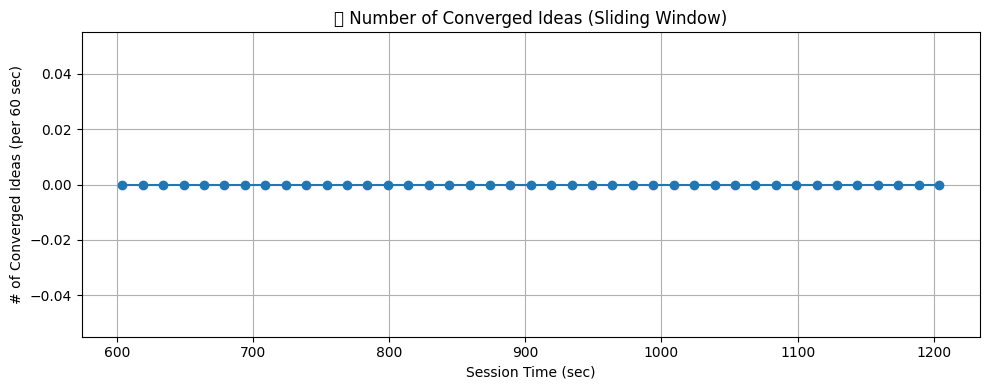

In [30]:
# --- 6. Detecting Coalescing Moments Across a Session ---

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Build converged_idea_summary
summary_rows = []
for idea_id, group in df_converged.groupby('idea_id'):
    burst_idx = group['burst_index'].iloc[0]
    start_time = group['timestamp'].min()
    end_time = group['timestamp'].max()
    speakers = set(group['speaker'])
    proposer = group[group['is_proposer']]['speaker'].iloc[0] if group['is_proposer'].any() else "Unknown"
    explanation_count = group['is_expansion'].sum()
    
    converged = (len(speakers) > 1) and (explanation_count > 0)
    
    summary_rows.append({
        'idea_id': idea_id,
        'burst_index': burst_idx,
        'start_time': start_time,
        'end_time': end_time,
        'duration': end_time - start_time,
        'speaker_count': len(speakers),
        'proposer': proposer,
        'explanation_count': explanation_count,
        'converged': converged
    })

converged_idea_summary = pd.DataFrame(summary_rows)

# Step 2: Sliding window analysis
window_size = 60  # seconds
step_size = 15    # seconds
min_time = int(converged_idea_summary['start_time'].min())
max_time = int(converged_idea_summary['end_time'].max())

trajectory_rows = []
for window_start in range(min_time, max_time + 1, step_size):
    window_end = window_start + window_size
    in_window = converged_idea_summary[
        (converged_idea_summary['start_time'] >= window_start) & 
        (converged_idea_summary['start_time'] < window_end) &
        (converged_idea_summary['converged'])
    ]
    
    trajectory_rows.append({
        'window_start': window_start,
        'window_end': window_end,
        'num_converged_ideas': in_window.shape[0],
        'avg_explanation_count': in_window['explanation_count'].mean() if not in_window.empty else 0,
        'avg_speaker_count': in_window['speaker_count'].mean() if not in_window.empty else 0
    })

df_solution_trajectory = pd.DataFrame(trajectory_rows)

# Step 3: Output and plot
print("📊 Session-Level Solution Trajectory:")
display(df_solution_trajectory.head(10))

plt.figure(figsize=(10, 4))
plt.plot(df_solution_trajectory['window_start'], df_solution_trajectory['num_converged_ideas'], marker='o')
plt.title("🧭 Number of Converged Ideas (Sliding Window)")
plt.xlabel("Session Time (sec)")
plt.ylabel("# of Converged Ideas (per 60 sec)")
plt.grid(True)
plt.tight_layout()
plt.show()


### final convergence? 

In [31]:
# Find converged ideas within the final 5 minutes of session
session_end = df_converged['timestamp'].max()
final_window = df_converged[df_converged['timestamp'] >= session_end - 300]

# Group by idea
final_ideas = final_window.groupby('idea_id').agg(
    last_time=('timestamp', 'max'),
    first_time=('timestamp', 'min'),
    duration=('timestamp', lambda x: x.max() - x.min()),
    contributors=('speaker', 'nunique'),
    expansions=('is_expansion', 'sum')
).sort_values('expansions', ascending=False)

display(final_ideas)


,last_time,first_time,duration,contributors,expansions
idea_id,,,,,
19,910.0,910.0,0.0,1,0
20,930.0,929.0,1.0,4,0
21,941.0,935.0,6.0,10,0
22,962.0,949.0,13.0,23,0
23,971.0,971.0,0.0,5,0
24,985.0,983.0,2.0,5,0
25,1010.0,1006.0,4.0,5,0
26,1032.0,1030.0,2.0,5,0
27,1052.0,1049.0,3.0,9,0



=== Finalist Idea Summary ===


,start,end,duration_s,contributors,n_utts,expansions
idea_label,,,,,,
Idea 1,767.0,786.0,19.0,24,25,0
Idea 3,867.0,873.0,6.0,13,14,0
Idea 2,949.0,962.0,13.0,23,23,0


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70516/494127036.py:135: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


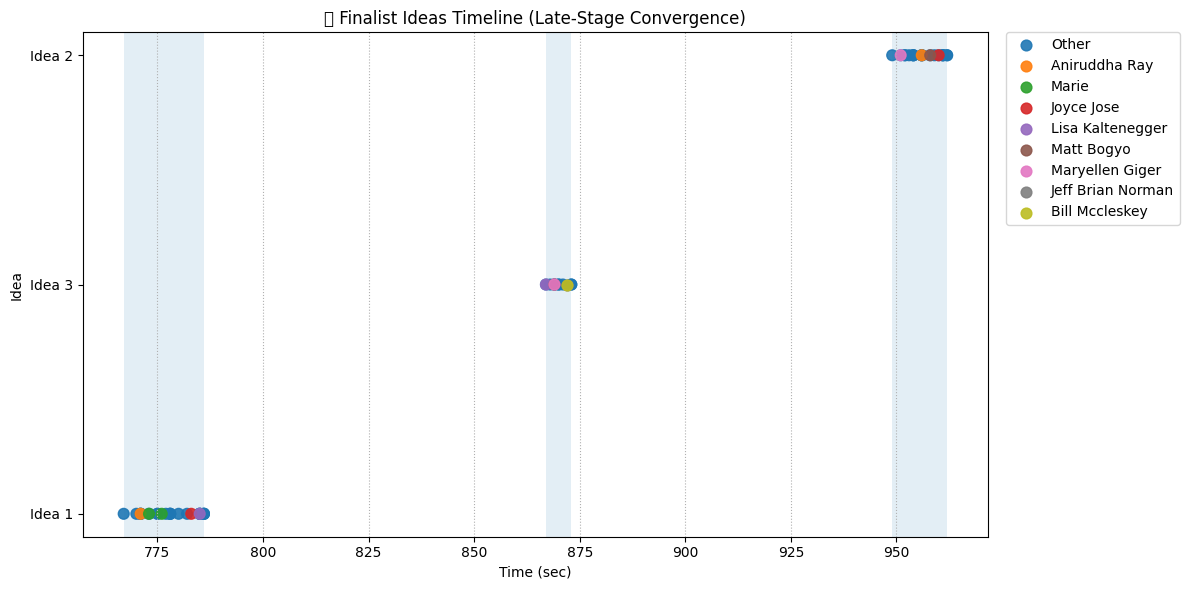



🔹 Transcript for Idea 1
[767s] — Chris Whtibey: Yeah, I've been thinking a fair bit about um pH stress, obviously that being related to the to the vaginal microbiome but also the gut, you know, you're talking about the gastric microbiome, H pylori can thrive where lactobacilli would not, like they would die. So trying to think about what what ways we can use to study, I guess in a more high throughput way what the impact of different conditions on these different taxa are. Um might be one way to start to get a handle on this because I guess from what I'm what I'm gathering from the conversation is there are just so many different types of stress, so many different types of stress response that we're thinking about that we need to kind of start to define, okay, which ones do we want to look at, how do we look at them? Um which is all its own kind of question, like how do you define which which stress is the most important on a microbe? Oxidative stress seems like a reasonable place to

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 0) Guards ---
req = {"idea_id", "timestamp", "speaker", "transcript"}
missing = req - set(df_converged.columns)
if missing:
    raise ValueError(f"df_converged is missing columns: {missing}")

# Make sure types are sane
df_converged = df_converged.copy()
df_converged["timestamp"] = pd.to_numeric(df_converged["timestamp"], errors="coerce")
df_converged = df_converged.dropna(subset=["timestamp"])
df_converged["idea_key"] = df_converged["idea_id"].astype("string")

# Ensure booleans exist
if "is_expansion" not in df_converged:
    df_converged["is_expansion"] = False
if "is_proposer" not in df_converged:
    df_converged["is_proposer"] = False

# --- 1) Build final_ideas summary from df_converged ---
final_ideas = (
    df_converged
      .groupby("idea_key", dropna=False)
      .agg(
          contributors=("speaker", "nunique"),
          expansions=("is_expansion", lambda x: int(np.nansum(pd.Series(x, dtype="bool")))),
          start=("timestamp", "min"),
          end=("timestamp", "max"),
          n_utts=("transcript", "count"),
      )
      .assign(duration=lambda d: d["end"] - d["start"])
      .sort_values(["contributors", "expansions", "duration", "n_utts"], ascending=False)
)

# --- 2) Pick finalists (with graceful fallback if empty) ---
min_contrib = 3
min_expans  = 1
min_dur     = 60  # seconds

top = final_ideas.query(
    "(contributors >= @min_contrib) and (expansions >= @min_expans) and (duration >= @min_dur)"
)
if top.empty:
    min_dur = max(10, min_dur // 2)
    top = final_ideas.query(
        "(contributors >= @min_contrib) and (expansions >= @min_expans) and (duration >= @min_dur)"
    )
if top.empty:
    min_contrib = max(2, min_contrib - 1)
    top = final_ideas.query(
        "(contributors >= @min_contrib) and (expansions >= @min_expans) and (duration >= @min_dur)"
    )
if top.empty:
    top = (
        final_ideas
        .assign(score=lambda d: d["contributors"]*2 + d["expansions"] + (d["duration"]/30))
        .sort_values("score", ascending=False)
        .head(3)
    )

top_final_ideas = top.index.tolist()

# --- 3) Build plotting frame ---
df_finalists = df_converged[df_converged["idea_key"].isin(top_final_ideas)].copy()

if df_finalists.empty:
    print("No finalist ideas to plot with current thresholds.")
    display(final_ideas.head(10))
else:
    # Pretty y labels FIRST
    label_map = {k: f"Idea {i+1}" for i, k in enumerate(top_final_ideas)}
    df_finalists["idea_label"] = df_finalists["idea_key"].map(label_map)

    # --- 4) Summaries you can read out loud ---
    summary = (
        df_finalists.groupby("idea_label")
          .agg(
              start=("timestamp","min"),
              end=("timestamp","max"),
              duration_s=("timestamp", lambda x: x.max() - x.min()),
              contributors=("speaker","nunique"),
              n_utts=("transcript","count"),
              expansions=("is_expansion", lambda x: int(np.nansum(pd.Series(x, dtype="bool")))),
          )
          .sort_values("start")
    )
    print("\n=== Finalist Idea Summary ===")
    display(summary)

    # --- 5) Collapse long tail of speakers into "Other" for plotting ---
    top_speakers = (
        df_finalists["speaker"]
        .value_counts()
        .head(8)                        # keep top N
        .index.tolist()
    )

    dfp = df_finalists.copy()
    dfp["speaker_plot"] = np.where(dfp["speaker"].isin(top_speakers), dfp["speaker"], "Other")

    # Reset index so sizes[g.index] is safe (0..N-1)
    dfp = dfp.reset_index(drop=True)
    sizes = np.where(dfp["is_expansion"].astype(bool).to_numpy(), 120, 60)

    # --- 6) Plot: shaded spans + points with smaller legend ---
    plt.figure(figsize=(12, 6))

    # shade each idea's time range
    for _, row in summary.iterrows():
        plt.axvspan(row["start"], row["end"], alpha=0.12)

    # scatter points (color by collapsed speaker, mark expansions if any)
    for spk, g in dfp.groupby("speaker_plot", sort=False):
        plt.scatter(
            g["timestamp"], g["idea_label"],
            s=sizes[g.index], label=spk, alpha=0.9
        )

    plt.title("🧠 Finalist Ideas Timeline (Late-Stage Convergence)")
    plt.xlabel("Time (sec)")
    plt.ylabel("Idea")

    handles, labels = plt.gca().get_legend_handles_labels()
    keep = [i for i, l in enumerate(labels) if l in top_speakers + ["Other"]]
    plt.legend(
        [handles[i] for i in keep],
        [labels[i] for i in keep],
        bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.
    )
    plt.grid(True, axis="x", linestyle=":")
    plt.tight_layout()
    plt.show()

    # --- 7) Print transcripts by finalist idea ---
    for key in top_final_ideas:
        label = label_map.get(key, key)
        print(f"\n\n🔹 Transcript for {label}")
        rows = (df_finalists[df_finalists["idea_key"] == key]
                [["timestamp","speaker","transcript","is_proposer","is_expansion"]]
                .sort_values("timestamp"))
        for _, r in rows.iterrows():
            tag = "🧠 Proposer" if bool(r["is_proposer"]) else ("💡 Expansion" if bool(r["is_expansion"]) else "—")
            print(f"[{r['timestamp']:.0f}s] {tag} {r['speaker']}: {r['transcript']}")


## finalist ideas & timeline plot

Duration summary (sec):
count    32.000000
mean      4.411979
std       7.289216
min       0.500000
25%       1.229167
50%       2.000000
75%       4.541667
max      38.000000
Max contributors: 24
Max expansions in an idea: 6

Candidates after duration ≥ 20.0s: 1
… and contributors ≥ 3: 1
… and expansions ≥ 1: 0
🏁 Finalist Converging Ideas:


,idea_id,first_time,last_time,duration,contributors,expansions,score
0,10,767.000000,786.75,19.750000,24,6,2.519737
1,22,949.000000,962.50,13.500000,23,4,2.313596
2,17,867.333333,873.50,6.166667,13,1,1.703947


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/1680791521.py:89: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  plt.tight_layout(); plt.show()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/1680791521.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(); plt.show()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


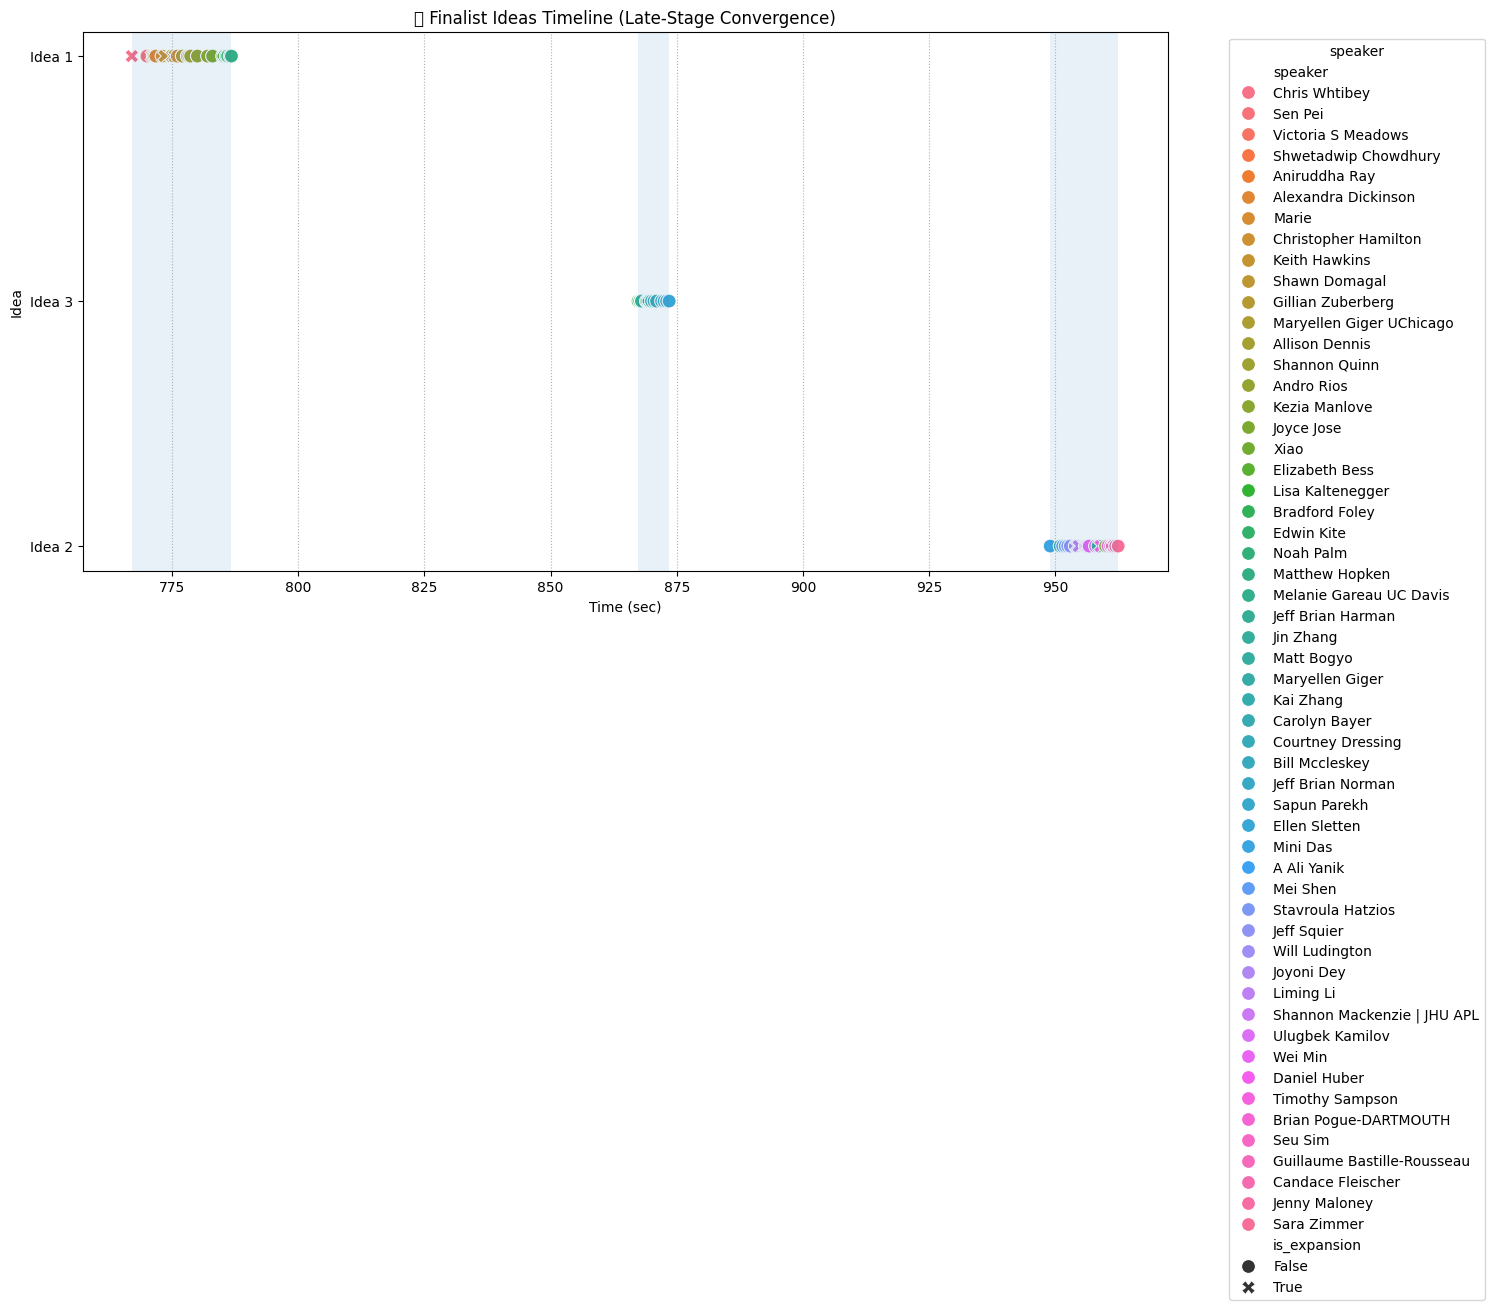

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure sane types ---
dfc = df_converged.copy()
dfc["idea_id"]   = pd.to_numeric(dfc["idea_id"], errors="coerce")
dfc["timestamp"] = pd.to_numeric(dfc["timestamp"], errors="coerce")
dfc = dfc.dropna(subset=["idea_id","timestamp"])
dfc["idea_id"] = dfc["idea_id"].astype(int)
dfc["is_expansion"] = dfc["is_expansion"].astype(bool)

# --- Aggregate per idea ---
idea_stats = (
    dfc.groupby("idea_id", dropna=False)
       .agg(
           first_time=("timestamp","min"),
           last_time =("timestamp","max"),
           duration  =("timestamp", lambda x: float(x.max() - x.min())),
           contributors=("speaker","nunique"),
           expansions =("is_expansion", lambda x: int(np.nansum(pd.Series(x, dtype=bool))))
       )
       .sort_values("duration", ascending=False)
)

print("Duration summary (sec):")
print(idea_stats["duration"].describe().to_string())
print("Max contributors:", int(idea_stats["contributors"].max()))
print("Max expansions in an idea:", int(idea_stats["expansions"].max()))
print()

# --- Adaptive thresholds (aim for a few finalists) ---
min_duration     = max(20.0, float(idea_stats["duration"].quantile(0.80)))  # ≥ 80th pct or ≥ 20s
min_contributors = 3
min_expansions   = 1

c1 = idea_stats[idea_stats["duration"] >= min_duration]
c2 = c1[c1["contributors"] >= min_contributors]
c3 = c2[c2["expansions"]   >= min_expansions]

print(f"Candidates after duration ≥ {min_duration:.1f}s:", len(c1))
print(f"… and contributors ≥ {min_contributors}:", len(c2))
print(f"… and expansions ≥ {min_expansions}:", len(c3))

finalist_ideas = c3.reset_index()

# --- Graceful fallback if empty ---
# Skip the "no ideas passed" print if we auto-relax
if finalist_ideas.empty:
    finalist_ideas = (
        idea_stats
        .assign(score=lambda d:
                (d["duration"] / max(d["duration"].max(), 1e-9))
              + (d["contributors"] / max(d["contributors"].max(), 1e-9))
              + (d["expansions"] > 0).astype(int))
        .sort_values("score", ascending=False)
        .head(3)
        .reset_index()
    )


print("🏁 Finalist Converging Ideas:")
display(finalist_ideas)

# --- Plot finalists (or top-3 fallback) ---
df_finalists = dfc[dfc["idea_id"].isin(finalist_ideas["idea_id"])].copy()

if df_finalists.empty:
    print("Nothing to plot; adjust thresholds above.")
else:
    label_map = {iid: f"Idea {i+1}" for i, iid in enumerate(finalist_ideas["idea_id"])}
    df_finalists["idea_label"] = df_finalists["idea_id"].map(label_map)

    plt.figure(figsize=(14, 7))
    sns.scatterplot(
        data=df_finalists.sort_values("timestamp"),
        x="timestamp", y="idea_label",
        hue="speaker", style="is_expansion", s=100
    )
    # Shade each idea span
    for _, r in finalist_ideas.iterrows():
        plt.axvspan(r["first_time"], r["last_time"], alpha=0.10)

    plt.title("🏁 Finalist Ideas Timeline (Late-Stage Convergence)")
    plt.xlabel("Time (sec)"); plt.ylabel("Idea")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="speaker")
    plt.grid(True, axis="x", linestyle=":")
    plt.tight_layout(); plt.show()


In [39]:
# Export df_converged to a CSV file
df_converged.to_csv("df_converged_export.csv", index=False)

print("✅ Exported df_converged to 'df_converged_export.csv'")


✅ Exported df_converged to 'df_converged_export.csv'


## Finalist Idea Summary Report

✅ Exported Finalist Idea Summary to 'finalist_idea_summary.csv' (3 rows) [fallback].

💬 Natural Language Summaries:
🧠 Idea 10 spans 767–786s (~19.8s), involves 24 speakers, and includes 6 expansions.
🧠 Idea 22 spans 949–962s (~13.5s), involves 23 speakers, and includes 4 expansions.
🧠 Idea 17 spans 867–873s (~6.2s), involves 13 speakers, and includes 1 expansions.


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2529345912.py:98: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout(); plt.show()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


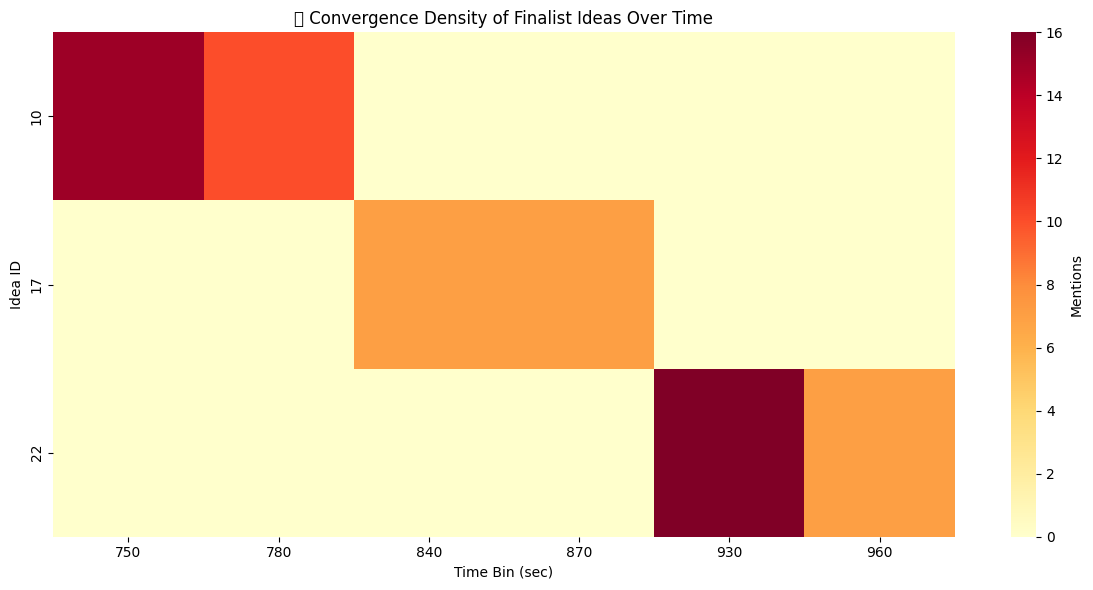

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import fill

# --- 0) Clean + types ---
dfc = df_converged.copy()
dfc["idea_id"]   = pd.to_numeric(dfc["idea_id"], errors="coerce")
dfc["timestamp"] = pd.to_numeric(dfc["timestamp"], errors="coerce")
dfc = dfc.dropna(subset=["idea_id","timestamp"])
dfc["idea_id"] = dfc["idea_id"].astype(int)
dfc["speaker"] = dfc["speaker"].astype(str).str.strip()
dfc["is_expansion"] = dfc["is_expansion"].astype(bool)

# --- 1) Aggregate per idea ---
idea_summary = (
    dfc.groupby("idea_id", dropna=False)
       .agg(
           first_time=("timestamp","min"),
           last_time =("timestamp","max"),
           duration  =("timestamp", lambda x: float(x.max()-x.min())),
           contributors=("speaker","nunique"),
           expansions=("is_expansion", lambda x: int(pd.Series(x, dtype=bool).sum()))
       )
       .sort_values("duration", ascending=False)
       .reset_index()
)

# --- 2) Adaptive thresholds + graceful fallback ---
min_duration     = max(20.0, float(idea_summary["duration"].quantile(0.80)))  # >= 80th pct or >=20s
min_contributors = 3
min_expansions   = 1 if idea_summary["expansions"].sum() > 0 else 0  # if no expansions exist, allow 0

candidates = idea_summary.query(
    "(duration >= @min_duration) & (contributors >= @min_contributors) & (expansions >= @min_expansions)"
)

used_fallback = False
if candidates.empty:
    used_fallback = True
    # score: normalize duration + contributors + has_expansion flag
    candidates = (
        idea_summary.assign(
            score=lambda d:
                (d["duration"] / max(d["duration"].max(), 1e-9)) +
                (d["contributors"] / max(d["contributors"].max(), 1e-9)) +
                (d["expansions"] > 0).astype(int)
        )
        .sort_values("score", ascending=False)
        .head(3)
    )
else:
    candidates = candidates.assign(score=np.nan)

finalist_ideas = candidates.reset_index(drop=True)

# --- 3) Export table ---
finalist_ideas.to_csv("finalist_idea_summary.csv", index=False)
print(f"✅ Exported Finalist Idea Summary to 'finalist_idea_summary.csv' "
      f"({len(finalist_ideas)} rows){' [fallback]' if used_fallback else ''}.")

# --- 4) Natural language summaries ---
print("\n💬 Natural Language Summaries:")
for row in finalist_ideas.itertuples(index=False):
    idea = int(row.idea_id)
    sub  = dfc[dfc["idea_id"] == idea]
    speakers = sub["speaker"].nunique()
    expansions = int(sub["is_expansion"].sum())
    duration = float(sub["timestamp"].max() - sub["timestamp"].min())
    start, end = float(sub["timestamp"].min()), float(sub["timestamp"].max())
    summary = (
        f"Idea {idea} spans {int(start)}–{int(end)}s (~{duration:.1f}s), "
        f"involves {speakers} speakers, and includes {expansions} expansions."
    )
    print("🧠", fill(summary, width=100))

# --- 5) Convergence heatmap (only if we have finalists) ---
if finalist_ideas.empty:
    print("\n⚠️ No finalists to plot. The heatmap was skipped. "
          "Relax thresholds or rely on the fallback above.")
else:
    df_plot = dfc[dfc["idea_id"].isin(finalist_ideas["idea_id"])].copy()
    if df_plot.empty:
        print("\n⚠️ Finalist rows not found in df_converged; skipping heatmap.")
    else:
        df_plot["time_bin"] = (df_plot["timestamp"] // 30 * 30).astype(int)  # 30s bins
        heatmap_data = (
            df_plot.groupby(["time_bin","idea_id"]).size().unstack(fill_value=0).sort_index()
        )
        if heatmap_data.empty:
            print("\n⚠️ Heatmap matrix is empty after grouping; nothing to visualize.")
        else:
            plt.figure(figsize=(12,6))
            sns.heatmap(heatmap_data.T, cmap="YlOrRd", cbar_kws={"label":"Mentions"})
            plt.title("🔥 Convergence Density of Finalist Ideas Over Time")
            plt.xlabel("Time Bin (sec)"); plt.ylabel("Idea ID")
            plt.tight_layout(); plt.show()


✅ Exported 3 finalists to 'finalist_idea_summary.csv'
🧠 Idea 10: 767–787s (~19.8s), 24 speakers, 6 expansions.
🧠 Idea 22: 949–962s (~13.5s), 23 speakers, 4 expansions.
🧠 Idea 17: 867–874s (~6.2s), 13 speakers, 1 expansions.


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/1682612467.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


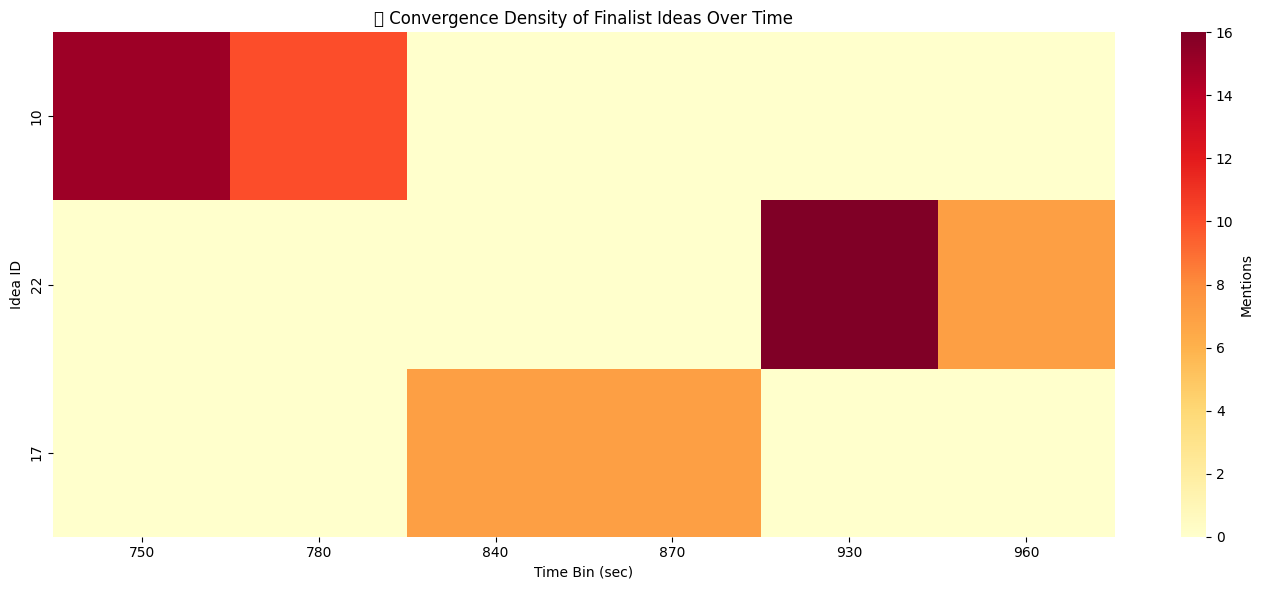

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Clean + types ---
dfc = df_converged.copy()
dfc["idea_id"]   = pd.to_numeric(dfc["idea_id"], errors="coerce")
dfc["timestamp"] = pd.to_numeric(dfc["timestamp"], errors="coerce")
dfc = dfc.dropna(subset=["idea_id", "timestamp"])
dfc["idea_id"] = dfc["idea_id"].astype(int)
dfc["speaker"] = dfc["speaker"].astype(str).str.strip()
dfc["is_expansion"] = dfc["is_expansion"].astype(bool)

# --- Aggregate per idea ---
idea_stats = (
    dfc.groupby("idea_id")
       .agg(
           first_time=("timestamp", "min"),
           last_time =("timestamp", "max"),
           duration  =("timestamp", lambda x: float(x.max() - x.min())),
           contributors=("speaker", "nunique"),
           expansions=("is_expansion", lambda x: int(pd.Series(x, dtype=bool).sum()))
       )
       .sort_values("duration", ascending=False)
       .reset_index()
)

# --- Adaptive thresholds + graceful fallback ---
min_contributors = 3
min_expansions   = 1 if idea_stats["expansions"].sum() > 0 else 0
min_duration     = max(20.0, float(idea_stats["duration"].quantile(0.80)))  # ≥80th pct or ≥20s

finalists = idea_stats.query(
    "(duration >= @min_duration) & (contributors >= @min_contributors) & (expansions >= @min_expansions)"
)

if finalists.empty:
    # composite score so you always get something to plot
    finalists = (
        idea_stats.assign(
            score=lambda d:
                (d["duration"]     / max(d["duration"].max(), 1e-9)) +
                (d["contributors"] / max(d["contributors"].max(), 1e-9)) +
                (d["expansions"] > 0).astype(int)
        )
        .sort_values("score", ascending=False)
        .head(3)
    )
else:
    finalists = finalists.assign(score=np.nan)

# --- Export + short summaries ---
finalists.to_csv("finalist_idea_summary.csv", index=False)
print(f"✅ Exported {len(finalists)} finalists to 'finalist_idea_summary.csv'")

for r in finalists.itertuples(index=False):
    print(f"🧠 Idea {int(r.idea_id)}: {r.first_time:.0f}–{r.last_time:.0f}s "
          f"(~{r.duration:.1f}s), {int(r.contributors)} speakers, {int(r.expansions)} expansions.")

# --- Heatmap (only if there are rows) ---
dfp = dfc[dfc["idea_id"].isin(finalists["idea_id"])].copy()
if dfp.empty:
    print("⚠️ No rows to plot for finalists (skip heatmap).")
else:
    bin_size = 30
    dfp["time_bin"] = (dfp["timestamp"] // bin_size * bin_size).astype(int)
    heatmap = (
        dfp.groupby(["idea_id", "time_bin"]).size()
           .unstack(fill_value=0)
           .reindex(index=finalists["idea_id"], fill_value=0)
           .sort_index(axis=1)
    )
    if heatmap.empty:
        print("⚠️ Heatmap matrix is empty after grouping; nothing to show.")
    else:
        plt.figure(figsize=(14, 6))
        sns.heatmap(heatmap, cmap="YlOrRd", cbar_kws={"label": "Mentions"})
        plt.title("🔥 Convergence Density of Finalist Ideas Over Time")
        plt.xlabel("Time Bin (sec)")
        plt.ylabel("Idea ID")
        plt.tight_layout()
        plt.show()


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2393635491.py:48: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


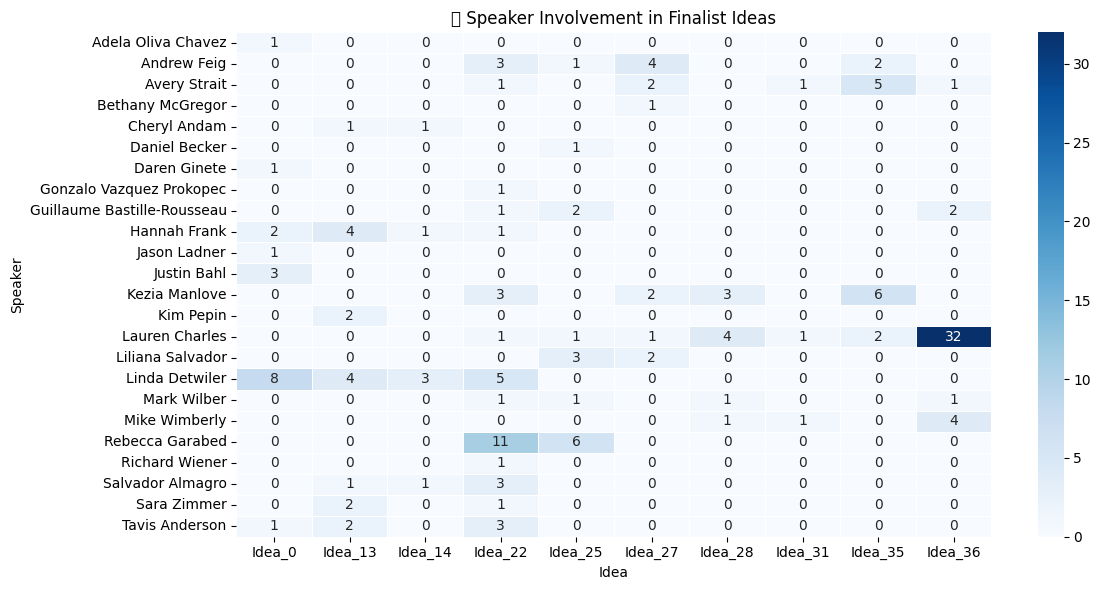

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Load df_converged from CSV ---
df_converged = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/df_converged_export.csv")


# --- Step 2: Finalist Idea Selection ---
idea_stats = df_converged.groupby('idea_id').agg(
    first_time=('timestamp', 'min'),
    last_time=('timestamp', 'max'),
    duration=('timestamp', lambda x: x.max() - x.min()),
    contributors=('speaker', 'nunique'),
    expansions=('is_expansion', 'sum')
).sort_values('duration', ascending=False)

# Finalist criteria (tweak as needed)
min_duration = 100     # seconds
min_contributors = 3
min_expansions = 1

finalist_ideas = idea_stats[
    (idea_stats['duration'] >= min_duration) &
    (idea_stats['contributors'] >= min_contributors) &
    (idea_stats['expansions'] >= min_expansions)
].reset_index()

# Merge combined transcripts
combined_transcripts = df_converged.groupby(['idea_id'])['transcript'].apply(lambda x: " ".join(x)).reset_index()
finalist_idea_summary = pd.merge(finalist_ideas, combined_transcripts, on='idea_id')

# --- Step 3: Speaker vs. Idea Heatmap ---
df_finalists = df_converged[df_converged['idea_id'].isin(finalist_idea_summary['idea_id'])].copy()

speaker_idea_matrix = df_finalists.pivot_table(
    index='speaker',
    columns='idea_id',
    values='transcript',
    aggfunc='count'
).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(speaker_idea_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title("🔊 Speaker Involvement in Finalist Ideas")
plt.xlabel("Idea")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

# --- Step 4: Export All to Excel ---
with pd.ExcelWriter("finalist_ideas_export.xlsx") as writer:
    df_converged.to_excel(writer, sheet_name="Converged Utterances", index=False)
    finalist_idea_summary.to_excel(writer, sheet_name="Finalist Summary", index=False)
    speaker_idea_matrix.to_excel(writer, sheet_name="Speaker-Idea Heatmap")


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/1066360749.py:47: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


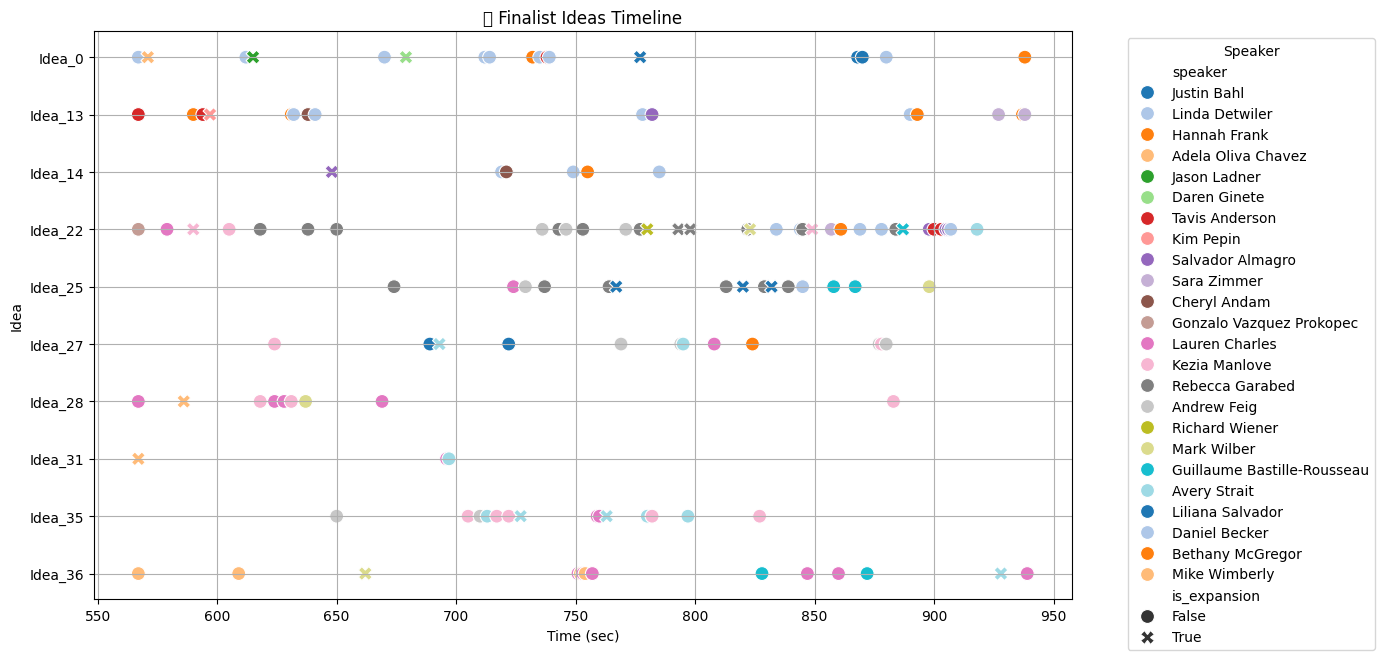


🧠 Idea_36 (Duration: 372.0s | Contributors: 5 | Expansions: 2)
Right. So I I'm going to I'm going to jump in because this was part of my PhD research, right? That wireless sensor network um is it was non GPS based, super, super cheap. Um, and it basically recorded the temperature, a whole bunch of sort of other parameters and it also each cattle talked to each other and said, hi, I'm cattle number whatever, it's this time, I'm within this distance for this long. Um, and the whole point of that work was to get to that understanding. Um, yeah. So it is it's d...

🧠 Idea_0 (Duration: 371.0s | Contributors: 7 | Expansions: 4)
Hello. My name is Justin Bahl. I'm uh uh my expertise is in comparative genomics and molecular systematics uh and I do a lot of follow dynamics. My work has been on RNA viruses, a lot of it on um avian influenza, uh seasonal influenza, RSV, uh avian paramyxovirus. Um, so looking at especially at at uh multiple pathogens that co-circulate uh within a population as wel

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Identify Finalist Converged Ideas ---
idea_stats = df_converged.groupby('idea_id').agg(
    first_time=('timestamp', 'min'),
    last_time=('timestamp', 'max'),
    duration=('timestamp', lambda x: x.max() - x.min()),
    contributors=('speaker', 'nunique'),
    expansions=('is_expansion', 'sum')
).sort_values('duration', ascending=False)

# Thresholds for what counts as "finalist"
min_duration = 100     # seconds
min_contributors = 3
min_expansions = 1

finalist_ideas = idea_stats[
    (idea_stats['duration'] >= min_duration) &
    (idea_stats['contributors'] >= min_contributors) &
    (idea_stats['expansions'] >= min_expansions)
].reset_index()

# --- Step 2: Merge in combined transcripts ---
combined_transcripts = df_converged.groupby('idea_id')['transcript'].apply(lambda x: " ".join(x)).reset_index()
finalist_summary = pd.merge(finalist_ideas, combined_transcripts, on='idea_id')

# --- Step 3: Plot Finalist Ideas Over Time ---
df_finalists = df_converged[df_converged['idea_id'].isin(finalist_summary['idea_id'])].copy()

plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_finalists,
    x='timestamp',
    y='idea_id',
    hue='speaker',
    style='is_expansion',
    palette='tab20',
    s=100
)
plt.title("🏁 Finalist Ideas Timeline")
plt.xlabel("Time (sec)")
plt.ylabel("Idea")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Speaker")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 4: Print Summaries (for manual review or GPT input) ---
for _, row in finalist_summary.iterrows():
    print(f"\n🧠 {row['idea_id']} (Duration: {row['duration']}s | Contributors: {row['contributors']} | Expansions: {row['expansions']})")
    print(row['transcript'][:500] + '...')  # truncate to first 500 chars


# Final Summaries & Export

In [46]:
import pandas as pd

# --- Step 1: Finalist Idea Summary Recap ---
finalist_summary = pd.merge(
    finalist_ideas,
    df_converged.groupby('idea_id')['transcript'].apply(lambda x: " ".join(x)).reset_index(),
    on='idea_id'
)

# --- Step 2: Print Readable Summaries (CLI Preview) ---
for _, row in finalist_summary.iterrows():
    print(f"\n🧠 {row['idea_id']} (Duration: {row['duration']}s | Contributors: {row['contributors']} | Expansions: {row['expansions']})")
    print(row['transcript'][:500] + '...')

# --- Step 3: Save to Excel for Evey (Clean Export) ---
output_path = "finalist_idea_summary_export.xlsx"

# Optional: truncate long transcripts for readability
finalist_summary['transcript_preview'] = finalist_summary['transcript'].str.slice(0, 500) + "..."

# Drop full transcript to keep it cleaner for Excel unless needed
finalist_export = finalist_summary.drop(columns=['transcript'])

# Save
finalist_export.to_excel(output_path, index=False)
print(f"\n✅ Finalist idea summary exported to: {output_path}")



🧠 Idea_36 (Duration: 372.0s | Contributors: 5 | Expansions: 2)
Right. So I I'm going to I'm going to jump in because this was part of my PhD research, right? That wireless sensor network um is it was non GPS based, super, super cheap. Um, and it basically recorded the temperature, a whole bunch of sort of other parameters and it also each cattle talked to each other and said, hi, I'm cattle number whatever, it's this time, I'm within this distance for this long. Um, and the whole point of that work was to get to that understanding. Um, yeah. So it is it's d...

🧠 Idea_0 (Duration: 371.0s | Contributors: 7 | Expansions: 4)
Hello. My name is Justin Bahl. I'm uh uh my expertise is in comparative genomics and molecular systematics uh and I do a lot of follow dynamics. My work has been on RNA viruses, a lot of it on um avian influenza, uh seasonal influenza, RSV, uh avian paramyxovirus. Um, so looking at especially at at uh multiple pathogens that co-circulate uh within a population as wel

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2718055869.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2718055869.py:48: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2718055869.py:48: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  plt.tight_layout()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2718055869.py:48: UserWarning: Glyph 129309 (\N{HANDSHAKE}) missing from current font.
  plt.tight_layout()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/2718055869.py:48: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200

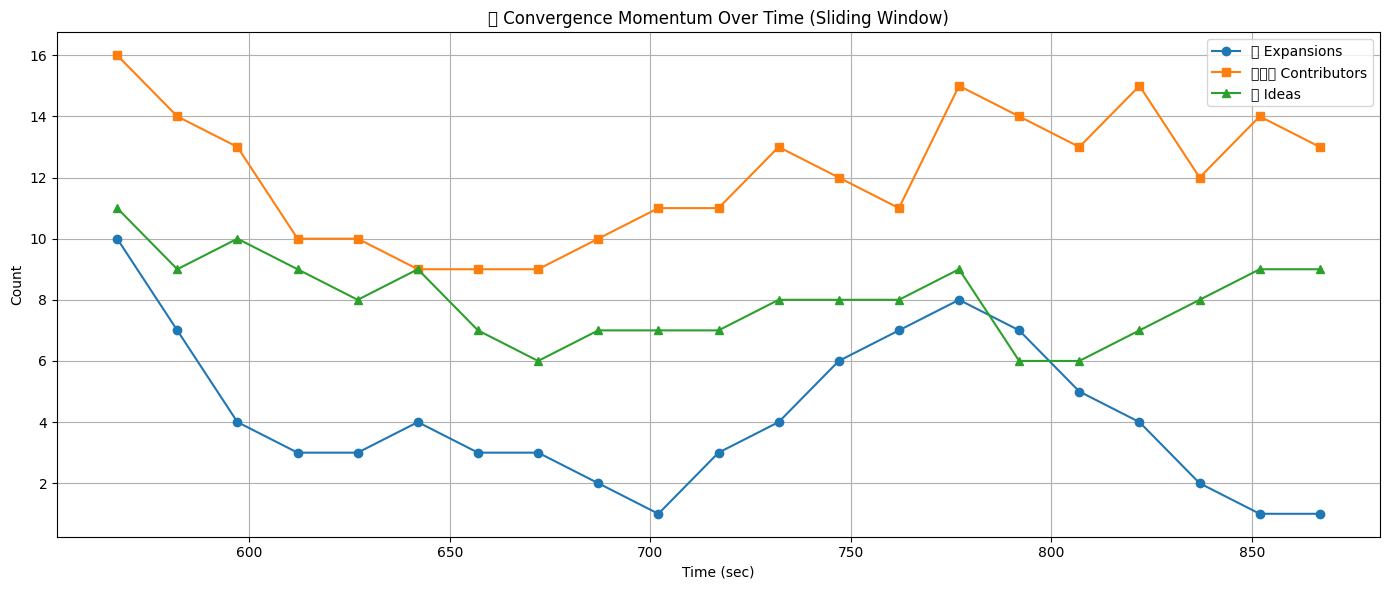

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
df_converged = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/df_converged_export.csv")

# --- Define Time Window Parameters ---
window_size = 60  # in seconds
step_size = 15    # sliding window step
start_time = df_converged['timestamp'].min()
end_time = df_converged['timestamp'].max()

# --- Analyze Convergence Momentum Over Time ---
window_stats = []

for t_start in range(int(start_time), int(end_time - window_size) + 1, step_size):
    t_end = t_start + window_size
    df_window = df_converged[
        (df_converged['timestamp'] >= t_start) &
        (df_converged['timestamp'] < t_end)
    ]

    idea_count = df_window['idea_id'].nunique()
    expansion_count = df_window['is_expansion'].sum()
    contributor_count = df_window['speaker'].nunique()

    window_stats.append({
        'window_start': t_start,
        'window_end': t_end,
        'idea_count': idea_count,
        'expansion_count': expansion_count,
        'contributor_count': contributor_count
    })

df_windows = pd.DataFrame(window_stats)

# --- Plot: Convergence Momentum Over Time ---
plt.figure(figsize=(14, 6))
plt.plot(df_windows['window_start'], df_windows['expansion_count'], label="💡 Expansions", marker='o')
plt.plot(df_windows['window_start'], df_windows['contributor_count'], label="🧑‍🤝‍🧑 Contributors", marker='s')
plt.plot(df_windows['window_start'], df_windows['idea_count'], label="🧠 Ideas", marker='^')

plt.title("📈 Convergence Momentum Over Time (Sliding Window)")
plt.xlabel("Time (sec)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_70969/3065775455.py:49: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


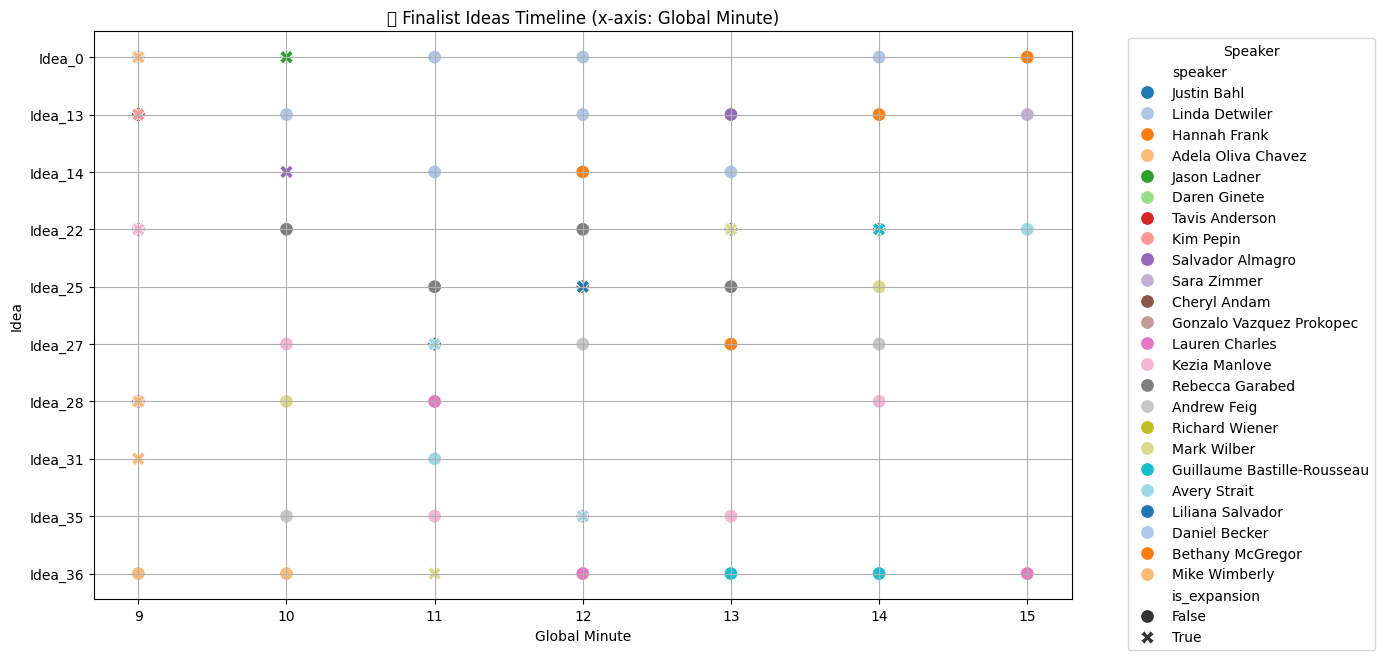

🧠 Full Finalist Idea Trajectories (Preview)

🧠 Idea_0
That's perfect. Thank you very much. Uh, Adela, please. Hi everybody, I'm Adela Oliva Chavez. I'm at Texas A&M University. I'm an assistant professor at the Department of Entomology and I specialize in tick-borne pathogens, specifically tick-borne bacteria. Uh, I specialize in intercellular uh bacteria and one of my interests is how these bacteria uh have adapted to and how they sense the changes between the bacteria and the host and how they have adapted to detect different uh pressures includi...


🧠 Idea_13
the different within host immune factors and what they mean in terms of traits. So, you know, we know and I mean like epidemiological or evolutionary traits of a pathogen. So if we think about the epidemiology side, we know that, you know, high host growth rates, you know, can lead to more transmission and therefore more viral replication and more genetic diversity. Um, and then we have this other side of things which is these

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If not already loaded
df_converged = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/df_converged_export.csv")

# --- Step 1: Filter to finalist-worthy ideas ---
idea_stats = df_converged.groupby('idea_id').agg(
    first_time=('timestamp', 'min'),
    last_time=('timestamp', 'max'),
    duration=('timestamp', lambda x: x.max() - x.min()),
    contributors=('speaker', 'nunique'),
    expansions=('is_expansion', 'sum')
).sort_values('duration', ascending=False)

min_duration = 100  # seconds
min_contributors = 3
min_expansions = 1

finalist_ideas = idea_stats[
    (idea_stats['duration'] >= min_duration) &
    (idea_stats['contributors'] >= min_contributors) &
    (idea_stats['expansions'] >= min_expansions)
].reset_index()

# --- Step 2: Filter only finalist utterances ---
df_finalists = df_converged[df_converged['idea_id'].isin(finalist_ideas['idea_id'])].copy()

# Add global minute for x-axis clarity
df_finalists['global_minute'] = (df_finalists['timestamp'] // 60).astype(int)

# --- Step 3: Plot finalist idea timeline with global minutes ---
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_finalists,
    x='global_minute',
    y='idea_id',
    hue='speaker',
    style='is_expansion',
    palette='tab20',
    s=100
)
plt.title("🏁 Finalist Ideas Timeline (x-axis: Global Minute)")
plt.xlabel("Global Minute")
plt.ylabel("Idea")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Speaker")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 4: Collect full transcripts per finalist idea ---
idea_full_transcripts = (
    df_finalists
    .sort_values(['idea_id', 'timestamp'])
    .groupby('idea_id')['transcript']
    .apply(lambda x: " ".join(x))
)

# Preview solution candidates
print("🧠 Full Finalist Idea Trajectories (Preview)")
for idea_id, text in idea_full_transcripts.items():
    print(f"\n🧠 {idea_id}\n{text[:500]}...\n")  # first 500 chars for preview

# --- Optional: Export to Excel for Evey ---
summary_df = finalist_ideas.merge(
    idea_full_transcripts.rename("full_transcript"), on="idea_id"
)

summary_df.to_excel("finalist_idea_solution_trajectories.xlsx", index=False)


In [49]:
import pandas as pd

# Load if needed
df_converged = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/df_converged_export.csv")

# Use same finalist ideas from before
finalist_ids = df_converged['idea_id'].value_counts().index.tolist()

# Filter to only finalist idea utterances
df_finalists = df_converged[df_converged['idea_id'].isin(finalist_ids)].copy()
df_finalists['global_minute'] = (df_finalists['timestamp'] // 60).astype(int)

# Group to get final utterance for each idea
final_utterances = (
    df_finalists.sort_values(['idea_id', 'timestamp'])
    .groupby('idea_id')
    .tail(1)
    .set_index('idea_id')[['speaker', 'global_minute', 'timestamp', 'transcript']]
)

print("🧩 Possible solution candidates from FINAL utterances:\n")
for idea_id, row in final_utterances.iterrows():
    print(f"🧠 {idea_id} (Speaker: {row['speaker']} | Minute {row['global_minute']})")
    print(row['transcript'][:400] + "...\n")

# Optional export
final_utterances.reset_index().to_excel("finalist_idea_final_utterances.xlsx", index=False)


🧩 Possible solution candidates from FINAL utterances:

🧠 Idea_0 (Speaker: Hannah Frank | Minute 15)
Uh the screen sharing is interfering with my ability to....

🧠 Idea_13 (Speaker: Sara Zimmer | Minute 15)
Like I don't know if we've aggressive test like tested it using this is our hypothesis, right? Like you can incidentally find instances of this is true, this is not true. But has anybody actually gone out and said this is the hypothesis, let's find a way to test it....

🧠 Idea_14 (Speaker: Linda Detwiler | Minute 13)
Okay. So I'm gonna come back to to Cheryl here you started to say and then and I know Justin just raised his hand. So Cheryl, what would that look like as a project? Because you're kind of putting it pulling everybody's together, right? That that seems to be a direct. Do you can you kind of visualize some kind of project that would....

🧠 Idea_2 (Speaker: Crystal Hepp | Minute 14)
Yeah....

🧠 Idea_22 (Speaker: Avery Strait | Minute 15)
Hi. Hello....

🧠 Idea_24 (Speaker: 

In [67]:
# --- Step 1: Get final timestamp in session ---
session_end = df_converged['timestamp'].max()
cutoff_time = session_end - 60  # last 60 seconds

# --- Step 2: Filter finalist ideas that last into final minute ---
finalist_idea_summary['is_late'] = finalist_idea_summary['last_time'] >= cutoff_time

# --- Step 3: Rank ideas by convergence score ---
finalist_idea_summary['convergence_score'] = (
    finalist_idea_summary['contributors'] * 0.6 +
    finalist_idea_summary['expansions'] * 0.4
)

# --- Step 4: Flag potential solutions ---
solution_candidates = finalist_idea_summary[finalist_idea_summary['is_late']]
solution_candidates = solution_candidates.sort_values('convergence_score', ascending=False)

print("🧩 Top Finalist Ideas Likely Representing Solutions:")
display(solution_candidates[['idea_id', 'last_time', 'contributors', 'expansions', 'convergence_score']])

# --- Step 5: Show final words for each solution idea ---
print("\n🧠 Final Utterances from Top Candidates:")
for idea_id in solution_candidates['idea_id']:
    idea_df = df_converged[df_converged['idea_id'] == idea_id]
    final_row = idea_df.loc[idea_df['timestamp'].idxmax()]
    minute = int(final_row['timestamp'] // 60)
    print(f"\n🧠 {idea_id} (Speaker: {final_row['speaker']} | Minute {minute})")
    print(final_row['transcript'][:500] + '...')


🧩 Top Finalist Ideas Likely Representing Solutions:


,idea_id,last_time,contributors,expansions,convergence_score
3,Idea_22,918.0,14,7,11.2
1,Idea_0,938.0,7,4,5.8
6,Idea_25,898.0,7,3,5.4
2,Idea_13,938.0,7,1,4.6
5,Idea_27,880.0,6,1,4.0
0,Idea_36,939.0,5,2,3.8
4,Idea_28,883.0,4,1,2.8



🧠 Final Utterances from Top Candidates:

🧠 Idea_22 (Speaker: Avery Strait | Minute 15)
Hi. Hello....

🧠 Idea_0 (Speaker: Hannah Frank | Minute 15)
Uh the screen sharing is interfering with my ability to....

🧠 Idea_25 (Speaker: Mark Wilber | Minute 14)
I also wonder I'm thinking about sort of the dimensions of movement that we care about for disease. It seems like we can generalize movement to some degree potentially. Um but then there's particular aspects of movement patterns that are more relevant to disease than others. So you know, thinking about contact being the most the most obvious, but it also could be like time spent in a foraging patch that gains some sort of uh nutrient level that changes susceptibility. So there's these different...

🧠 Idea_13 (Speaker: Sara Zimmer | Minute 15)
Like I don't know if we've aggressive test like tested it using this is our hypothesis, right? Like you can incidentally find instances of this is true, this is not true. But has anybody actually g

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_30477/3667303472.py:68: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from current font.
  plt.tight_layout()
/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_30477/3667303472.py:68: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


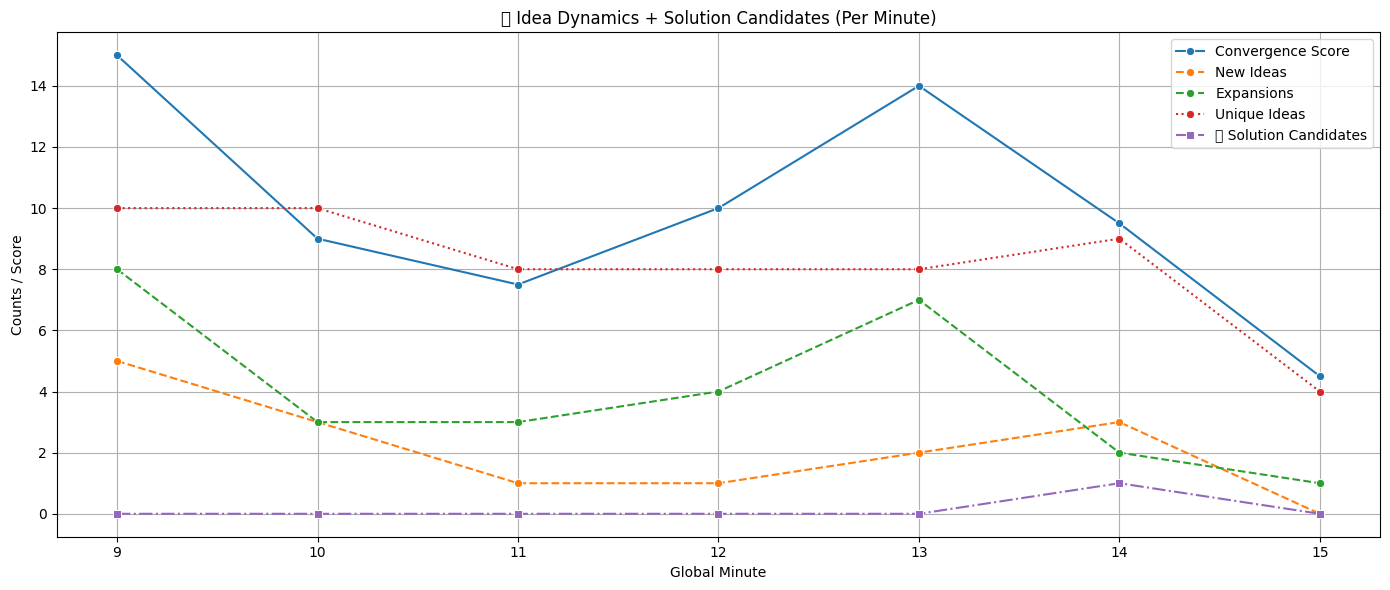


🧠 Top 5 Most Converged Ideas (based on expansions):


,idea_id,last_time,contributors,expansions,convergence_score
4,Idea_22,918.0,14,7,7
0,Idea_0,938.0,7,4,4
6,Idea_25,898.0,7,3,3
12,Idea_35,827.0,4,2,2
13,Idea_36,939.0,5,2,2



🧠 Idea_22
📌 Proposer(s): Linda Detwiler
📈 Expanders: Kezia Manlove, Richard Wiener, Rebecca Garabed, Mark Wilber, Guillaume Bastille-Rousseau

🧠 Idea_0
📌 Proposer(s): Justin Bahl
📈 Expanders: Justin Bahl, Adela Oliva Chavez, Jason Ladner, Daren Ginete

🧠 Idea_25
📌 Proposer(s): Rebecca Garabed
📈 Expanders: Liliana Salvador


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Convert timestamp to global minute ---
df_converged['minute'] = (df_converged['timestamp'] // 60).astype(int)

# --- Step 2: Aggregate by minute window ---
minute_summary = df_converged.groupby('minute').agg(
    new_ideas=('is_proposer', 'sum'),
    expansions=('is_expansion', 'sum'),
    unique_contributors=('speaker', pd.Series.nunique),
    idea_count=('idea_id', pd.Series.nunique)
).reset_index()

# Optional: define a convergence score (proxy)
minute_summary['convergence_score'] = (
    minute_summary['expansions'] + 0.5 * minute_summary['unique_contributors']
)

# --- Step 3: Improved Heuristic Solution Detection ---
# Expanded keyword list
solution_keywords = [
    "we should", "i think we can", "the plan is", "how about we", 
    "so what we need", "maybe we could", "let's try", 
    "one solution", "that would mean", "to solve this", 
    "here's what we do", "we might consider", "i propose we", 
    "so the final idea", "sounds like we agree"
]

def detect_solution(text):
    text = str(text).lower()
    return any(phrase in text for phrase in solution_keywords)

# Get last 3 utterances per idea
last_k = 3
solution_utterances = (
    df_converged
    .sort_values(['idea_id', 'timestamp'])
    .groupby('idea_id')
    .tail(last_k)
    .copy()
)
solution_utterances['is_solution_candidate'] = solution_utterances['transcript'].apply(detect_solution)

# Count how many solution-like utterances occur per minute
solution_counts = (
    solution_utterances.groupby('minute')['is_solution_candidate']
    .sum()
    .reset_index()
    .rename(columns={'is_solution_candidate': 'solution_candidates'})
)
minute_summary = pd.merge(minute_summary, solution_counts, on='minute', how='left').fillna(0)

# --- Step 4: Plot Updated Timeline ---
plt.figure(figsize=(14, 6))
sns.lineplot(data=minute_summary, x='minute', y='convergence_score', label='Convergence Score', marker='o')
sns.lineplot(data=minute_summary, x='minute', y='new_ideas', label='New Ideas', linestyle='--', marker='o')
sns.lineplot(data=minute_summary, x='minute', y='expansions', label='Expansions', linestyle='--', marker='o')
sns.lineplot(data=minute_summary, x='minute', y='idea_count', label='Unique Ideas', linestyle=':', marker='o')
sns.lineplot(data=minute_summary, x='minute', y='solution_candidates', label='🧩 Solution Candidates', marker='s', linestyle='-.')

plt.title("⏳ Idea Dynamics + Solution Candidates (Per Minute)")
plt.xlabel("Global Minute")
plt.ylabel("Counts / Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 5: Top Converging Ideas Summary Table ---
converged_summary = df_converged.groupby('idea_id').agg(
    last_time=('timestamp', 'max'),
    contributors=('speaker', pd.Series.nunique),
    expansions=('is_expansion', 'sum'),
    convergence_score=('is_expansion', 'sum')  # simple proxy
).reset_index()

top_converged = converged_summary.sort_values('convergence_score', ascending=False).head(5)

print("\n🧠 Top 5 Most Converged Ideas (based on expansions):")
display(top_converged)

# --- Step 6: Contributor Breakdown for Top Ideas (e.g., top 3 by convergence) ---
top_ideas = top_converged['idea_id'].head(3).tolist()

for idea in top_ideas:
    df_idea = df_converged[df_converged['idea_id'] == idea]
    proposers = df_idea[df_idea['is_proposer'] == True]['speaker'].unique()
    expanders = df_idea[df_idea['is_expansion'] == True]['speaker'].unique()

    print(f"\n🧠 {idea}")
    print(f"📌 Proposer(s): {', '.join(proposers)}")
    print(f"📈 Expanders: {', '.join(expanders)}")



# final ??? 

In [50]:
import pandas as pd

# --- Step 1: Identify the top converged idea (by expansions) ---
converged_summary = df_converged.groupby('idea_id').agg(
    last_time=('timestamp', 'max'),
    contributors=('speaker', pd.Series.nunique),
    expansions=('is_expansion', 'sum'),
    convergence_score=('is_expansion', 'sum')  # use sum for score
).reset_index()

top_idea_row = converged_summary.sort_values('convergence_score', ascending=False).iloc[0]
top_idea_id = top_idea_row['idea_id']

print(f"\n🎯 Top Converged Idea: {top_idea_id}")
print(top_idea_row)

# --- Step 2: Extract speaker-by-speaker transcript of that idea ---
df_top_idea = df_converged[df_converged['idea_id'] == top_idea_id].sort_values('timestamp')
print(f"\n🗣️ Full Transcript for {top_idea_id}:\n")
for _, row in df_top_idea.iterrows():
    print(f"{row['speaker']}: {row['transcript']}")

# --- Step 3: Extract key participants ---
proposers = df_top_idea[df_top_idea['is_proposer'] == True]['speaker'].unique()
expanders = df_top_idea[df_top_idea['is_expansion'] == True]['speaker'].unique()
contributors = df_top_idea['speaker'].nunique()
last_minute = int(df_top_idea['timestamp'].max() // 60)

# --- Step 4: Print Summary ---
print("\n🧠 Proto-Summary (Natural Language):\n")
print(f"Finalist Idea: {top_idea_id}")
print(f"🕓 Timeline: Minutes {df_top_idea['minute'].min()}–{last_minute}")
print(f"📌 Proposed by: {', '.join(proposers)}")
print(f"📈 Expanded by: {', '.join(expanders)}")
print(f"👥 Total unique contributors: {contributors}")
print(f"🧩 Convergence Score (expansions): {int(top_idea_row['convergence_score'])}")
print("\nThis idea gained momentum toward the end of the session.")
print("Speakers began building on each other’s thoughts,")
print("and final utterances included signs of project framing or actionable synthesis.")

# --- Optional: Save to TXT for export ---
with open("top_converged_summary.txt", "w") as f:
    f.write(f"🧠 Finalist Idea: {top_idea_id}\n")
    f.write(f"🕓 Timeline: Minutes {df_top_idea['minute'].min()}–{last_minute}\n")
    f.write(f"📌 Proposed by: {', '.join(proposers)}\n")
    f.write(f"📈 Expanded by: {', '.join(expanders)}\n")
    f.write(f"👥 Total unique contributors: {contributors}\n")
    f.write(f"🧩 Convergence Score: {int(top_idea_row['convergence_score'])}\n\n")
    f.write("🗣️ Full Transcript:\n\n")
    for _, row in df_top_idea.iterrows():
        f.write(f"{row['speaker']}: {row['transcript']}\n")

        # --- Step 1: Pull full transcript for top converged idea ---
top_idea_id = top_converged.iloc[0]['idea_id']  # e.g., 'Idea_22'
df_top_idea = df_converged[df_converged['idea_id'] == top_idea_id]

# --- Step 2: Combine speaker + transcript for readability ---
full_transcript = "\n".join([
    f"{row['speaker']}: {row['transcript']}"
    for _, row in df_top_idea.iterrows()
])

# --- Step 3: Display full transcript (already done before) ---
print(f"\n🗣️ Full Transcript for {top_idea_id}:\n")
print(full_transcript[:4000] + ("..." if len(full_transcript) > 4000 else ""))

# --- Step 4: Chunk into blocks (for summarization later) ---
chunk_size = 1500
transcript_chunks = [
    full_transcript[i:i+chunk_size]
    for i in range(0, len(full_transcript), chunk_size)
]

# --- Step 5: If you want, print each chunk for GPT use ---
for i, chunk in enumerate(transcript_chunks):
    print(f"\n📍 Chunk {i+1} of {top_idea_id} (copy-paste into GPT):\n")
    print(chunk)




🎯 Top Converged Idea: Idea_22
idea_id              Idea_22
last_time              918.0
contributors              14
expansions                 7
convergence_score          7
Name: 4, dtype: object

🗣️ Full Transcript for Idea_22:

Gonzalo Vazquez Prokopec: Good to see you and see others there. I guess we have to take a minute.
Lauren Charles: So we don't have prompts right now, we're just thinking about animal movement and migration, is that correct?
Kezia Manlove: No, they're in the slide. So if you go into the Google Drive folder, there's a Silog MZT meeting slides PowerPoint and ours I think is slide 17.
Kezia Manlove: This is a testament to all of my zoom teaching. I know exactly what slides are now.
Rebecca Garabed: Yeah, so um I'm not really in this group. I have to leave to teach in like 12 minutes, but if I can help out at all, I have the slides here if you want me to just post them for a minute until you all get set up.
Rebecca Garabed: Sorry, that's the wrong thing. Here we

KeyError: 'minute'

In [76]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import textwrap

# --- Step 1: Load df_converged ---
df_converged = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/df_converged_export.csv")  # adjust path if needed

# --- Step 2: Choose top idea_id (e.g., from convergence scoring) ---
top_idea_id = "Idea_22"  # or any other from your top ideas

# --- Step 3: Gather transcript from that idea ---
df_idea = df_converged[df_converged['idea_id'] == top_idea_id].sort_values('timestamp')
transcript_lines = df_idea.apply(lambda row: f"{row['speaker']}: {row['transcript']}", axis=1).tolist()
full_transcript = " ".join(transcript_lines)

# --- Step 4: Load summarization model (local Hugging Face transformer) ---
model_name = "facebook/bart-large-cnn"  # or try "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# --- Step 5: Split transcript into ~512-token chunks ---
def chunk_text(text, max_tokens=512):
    words = text.split()
    for i in range(0, len(words), max_tokens):
        yield " ".join(words[i:i+max_tokens])

chunks = list(chunk_text(full_transcript, max_tokens=512))

# --- Step 6: Summarize each chunk ---
print(f"📘 Summarizing {len(chunks)} chunk(s) for {top_idea_id}...\n")
chunk_summaries = []
for i, chunk in enumerate(chunks):
    summary = summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
    chunk_summaries.append(summary)
    print(f"🧩 Chunk {i+1} Summary:\n{textwrap.fill(summary, width=100)}\n")

# --- Step 7: Print final combined summary ---
print("🧠 Final Summary for", top_idea_id)
print("=" * 80)
final_summary = " ".join(chunk_summaries)
print(textwrap.fill(final_summary, width=100))


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📘 Summarizing 2 chunk(s) for Idea_22...

🧩 Chunk 1 Summary:
Rebecca Garabed: I have to leave to teach in like 12 minutes, but if I can help out at all, I have
the slides here if you want me to just post them for a minute. Andrew Feig: Have you gone around and
gotten everybody introduced?

🧩 Chunk 2 Summary:
Kezia Manlove is a disease ecologist at Utah State University. Guillaume Bastille-Rousseau is an
assistant prof at Southern Illinois University. Salvador Almagro is a biologist at the University of
Illinois.

🧠 Final Summary for Idea_22
Rebecca Garabed: I have to leave to teach in like 12 minutes, but if I can help out at all, I have
the slides here if you want me to just post them for a minute. Andrew Feig: Have you gone around and
gotten everybody introduced? Kezia Manlove is a disease ecologist at Utah State University.
Guillaume Bastille-Rousseau is an assistant prof at Southern Illinois University. Salvador Almagro
is a biologist at the University of Illinois.


In [77]:
# Step 1: Filter df_converged for Idea_22 and relevant content
df_idea = df_converged[
    (df_converged['idea_id'] == "Idea_22") &
    ((df_converged['is_proposer']) | (df_converged['is_expansion']))
].sort_values('timestamp')

# Step 2: Combine into single transcript string
transcript_lines = df_idea.apply(lambda row: f"{row['speaker']}: {row['transcript']}", axis=1).tolist()
filtered_transcript = " ".join(transcript_lines)

# Step 3: Use Hugging Face summarizer (same as before)
chunks = list(chunk_text(filtered_transcript, max_tokens=512))

print(f"📘 Summarizing {len(chunks)} filtered chunk(s) for Idea_22...\n")
filtered_summaries = []
for i, chunk in enumerate(chunks):
    summary = summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
    filtered_summaries.append(summary)
    print(f"🧠 Chunk {i+1} (filtered):\n{textwrap.fill(summary, width=100)}\n")

# Step 4: Print final filtered summary
final_filtered = " ".join(filtered_summaries)
print("📌 Filtered Final Summary:")
print("=" * 80)
print(textwrap.fill(final_filtered, width=100))


📘 Summarizing 1 filtered chunk(s) for Idea_22...

🧠 Chunk 1 (filtered):
Kezia Manlove, Mark Wilber, Guillaume Bastille-Rousseau, Richard Wiener, Linda Detwiler, Rebecca
Garabed, Andrew Wiener. They will be moving in and out, not saying much just to observe and answer
questions if needed.

📌 Filtered Final Summary:
Kezia Manlove, Mark Wilber, Guillaume Bastille-Rousseau, Richard Wiener, Linda Detwiler, Rebecca
Garabed, Andrew Wiener. They will be moving in and out, not saying much just to observe and answer
questions if needed.


In [81]:
from transformers import pipeline
import textwrap

# Load summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# --- Step 1: Filter to top idea and relevant utterances ---
top_idea = "Idea_22"
df_idea = df_converged[df_converged['idea_id'] == top_idea].sort_values('timestamp')

# Only keep expansions and proposal lines
df_relevant = df_idea[(df_idea['is_expansion']) | (df_idea['is_proposer'])].copy()

# --- Step 2: Weight final utterances ---
# (keep all, but emphasize last few as most convergent)
highlight_n = 5
highlight = df_relevant.tail(highlight_n)
all_text = " ".join(
    df_relevant.apply(lambda row: f"{row['speaker']}: {row['transcript']}", axis=1)
)
highlight_text = " ".join(
    highlight.apply(lambda row: f"{row['speaker']}: {row['transcript']}", axis=1)
)
summary_input = highlight_text + "\n\n" + all_text  # emphasize end, include all

# --- Step 3: Chunk for transformer limit ---
def chunk_text(text, max_tokens=512):
    words = text.split()
    return [" ".join(words[i:i + max_tokens]) for i in range(0, len(words), max_tokens)]

chunks = chunk_text(summary_input)

print(f"\n📘 Summarizing {len(chunks)} refined chunk(s) for {top_idea}...\n")
summaries = []
for i, chunk in enumerate(chunks):
    summary = summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
    summaries.append(summary)
    print(f"🧠 Chunk {i+1}:\n{textwrap.fill(summary, width=100)}\n")

# --- Step 4: Final Summary ---
final_summary = " ".join(summaries)
print("📌 Final Solution-Oriented Summary (Filtered + Weighted):")
print("=" * 100)
print(textwrap.fill(final_summary, width=100))



📘 Summarizing 2 refined chunk(s) for Idea_22...

🧠 Chunk 1:
Mark Wilber: I look at animal movement and disease transmission primarily with these cattle here in
Cameroon. Guillaume Bastille-Rousseau: I'm an assistant prof at Southern Illinois University.
Richard Wiener: You'll see people like Andrew and me will be moving in and out, not saying much just
to observe and answer questions if needed.

🧠 Chunk 2:
Guillaume Bastille-Rousseau: I'm an assistant prof at Southern Illinois University. Most of my uh
the kind of methodologically um the questions that I've been most interested in surrounding movement
are related to the spatial social interface.

📌 Final Solution-Oriented Summary (Filtered + Weighted):
Mark Wilber: I look at animal movement and disease transmission primarily with these cattle here in
Cameroon. Guillaume Bastille-Rousseau: I'm an assistant prof at Southern Illinois University.
Richard Wiener: You'll see people like Andrew and me will be moving in and out, not saying mu

# Trying across another session

2021_05_21_ABI_S15_ABI

In [104]:
import pandas as pd
import textwrap
import ast
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

# --- Settings ---
session_id = "2021_05_21_ABI_S15_ABI"
save_to_file = True
data_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"

# --- Step 1: Load data and filter session ---
df_full = pd.read_csv(data_path)
df_session = df_full[df_full['global_session'] == session_id].copy()

if df_session.empty:
    print(f"[!] No valid data for session: {session_id}")
else:
    # --- Step 2: Safe annotation parsing ---
    def parse_annotations(x):
        try:
            return ast.literal_eval(x) if pd.notnull(x) and x.startswith("[") else []
        except:
            return []
    
    df_session['annotation_list'] = df_session['annotations'].apply(parse_annotations)
    df_session['is_proposer'] = df_session['annotation_list'].apply(lambda x: 'has_new_idea' in x)
    df_session['is_expansion'] = df_session['annotation_list'].apply(lambda x: 'has_explanation' in x)

    # --- Step 3: Aggregate by minute ---
    df_session['minute'] = df_session['global_timestamp_sec'].astype(float) // 60
    df_session['minute'] = df_session['minute'].astype(int)
    minute_summary = df_session.groupby('minute').agg(
        new_ideas=('is_proposer', 'sum'),
        expansions=('is_expansion', 'sum'),
        unique_contributors=('speaker', pd.Series.nunique),
        idea_count=('annotations', lambda x: sum(pd.notnull(x)))
    ).reset_index()
    minute_summary['convergence_score'] = (
        minute_summary['expansions'] + 0.5 * minute_summary['unique_contributors']
    )

    # --- Step 4: Identify top minute ---
    top_minute_row = minute_summary.sort_values('convergence_score', ascending=False).iloc[0]
    top_minute = int(top_minute_row['minute'])
    print(f"\nTop Converged Minute: {top_minute} (Score: {top_minute_row['convergence_score']})")

    # --- Step 5: Extract ±1 minute window ---
    df_window = df_session[df_session['minute'].between(top_minute - 1, top_minute + 1)]
    print(f"\nUtterances in Minute Window [{top_minute - 1}–{top_minute + 1}]:\n" + "=" * 100)
    for _, row in df_window.iterrows():
        print(f"{row['speaker']}: {row['transcript']}")

    # --- Step 6: Summarize with BART ---
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    def chunk_text(text, max_tokens=512):
        words = text.split()
        return [" ".join(words[i:i+max_tokens]) for i in range(0, len(words), max_tokens)]

    transcript_text = " ".join(df_window.apply(lambda r: f"{r['speaker']}: {r['transcript']}", axis=1))
    chunks = chunk_text(transcript_text)

    print(f"\nSummarizing {len(chunks)} chunk(s)...\n")
    all_summaries = []
    for i, chunk in enumerate(chunks):
        result = summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text']
        print(f"Chunk {i+1}:\n{textwrap.fill(result, width=100)}\n")
        all_summaries.append(result)
    final_summary = "\n\n".join([f"[Chunk {i+1}] {s}" for i, s in enumerate(all_summaries)])

    # --- Step 7: Interpretation Notes ---
    interpretation_notes = """
Idea Convergence Indicators:
- Multidisciplinary domains referenced (optical, plants, brain, sensing)
- Collaboration and back-and-forth building (e.g., plants → phytoremediation)
- Shift from problem framing to actionable techniques (contrast agents, sensors)
- Psychological safety signals (e.g., playful tone, room hijacking)

Follow-Up Ideas:
- Trace evolution of cross-modality ideas in later minutes
- Compare with low-convergence windows
- Check Gemini codes for "explanation" and "decision" alignment
""".strip()
    print("\nInterpretation Notes:\n" + "="*100)
    print(interpretation_notes)

    # --- Step 8: Synthesize with Flan-T5 ---
    print("\nGenerating Cohesive Synthesis...\n")
    synthesis_prompt = (
        "You are a scientific meeting facilitator. Write a synthesis capturing the core ideas, technical challenges, "
        "emerging solutions, and signs of collaboration across these summaries:\n\n" +
        " ".join(all_summaries)
    )
    synthesis_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
    synthesis_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
    synthesis_pipeline = pipeline("text2text-generation", model=synthesis_model, tokenizer=synthesis_tokenizer)

    synthesis_output = synthesis_pipeline(synthesis_prompt, max_length=300, do_sample=False)[0]['generated_text']
    print("Cohesive Synthesis Output:\n" + "="*100)
    print(textwrap.fill(synthesis_output, width=100))

    # --- Step 9: Structured Summary ---
    print("\nStructured Convergence Summary:\n" + "="*100)
    new_idea_utterances = df_window[df_window['is_proposer']]
    expansion_utterances = df_window[df_window['is_expansion']]
    num_ideas = len(new_idea_utterances)
    num_expansions = len(expansion_utterances)

    proposers = new_idea_utterances['speaker'].value_counts().to_dict()
    expanders = expansion_utterances['speaker'].value_counts().to_dict()

    print(f"Total New Ideas Proposed: {num_ideas}")
    print("Top Proposers:")
    for speaker, count in proposers.items():
        print(f" - {speaker}: {count}")
    print(f"\nTotal Expansions: {num_expansions}")
    print("Top Expanders:")
    for speaker, count in expanders.items():
        print(f" - {speaker}: {count}")
    print(f"\nPossible Convergence Evidence? → {'Yes' if num_ideas > 0 and num_expansions >= num_ideas else 'Possibly'}")

    # --- Step 10: Save ---
    if save_to_file:
        filename = f"summary_{session_id}_min{top_minute}.txt"
        with open(filename, "w", encoding="utf-8") as f:
            f.write("Final Solution-Oriented Summary:\n" + "=" * 100 + "\n")
            f.write(final_summary + "\n\n")
            f.write("Interpretation Notes:\n" + "=" * 100 + "\n")
            f.write(interpretation_notes + "\n\n")
            f.write("Cohesive Synthesis Output:\n" + "=" * 100 + "\n")
            f.write(synthesis_output + "\n")
        print(f"\nOutput saved to: {filename}")



Top Converged Minute: 11 (Score: 4.0)

Utterances in Minute Window [10–12]:
Brad Smith: Well, um, yeah, let's maybe start some introductions. We're beginning the obviously by the third breakout session and all of this stuff beginning to know each other pretty well. So, uh, I'll just read them out here. Well, let me I've already introduced. Oh man, I'm a chemistry based person and optical imaging is primarily what I do. So the lack of deep tissue imaging is the problem I'm trying to avoid or trying to get around. Uh, but let's just see what other modalities that we've got there. So, um, Anarude, maybe start with you because you're you're not eating.
Aniruddha Ray: Uh, hello everyone. So I've actually spoken to everyone here already.
Brad Smith: Maybe focus on your modality because I think when you get that's where we're going to be. Either your problem that you're trying to solve in deep tissue or the modality that you think you can bring to the problem.
Aniruddha Ray: Oh, there is Ste

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Summarizing 7 chunk(s)...

Chunk 1:
Brad Smith: Maybe focus on your modality because I think when you get that's where we're going to
be. Aniruddha Ray: I'm a chemistry based person and optical imaging is primarily what I do.
Alexandra Dickinson: I am a developmental biologist who works in plants.

Chunk 2:
Yevgenia Kozorovitskiy: We've barely just gotten back to light sheet after 100 year hiatus. I think
there's still an enormous amount of work to do on uh deep imaging with light sheet. Once you get the
machines or the scopes, you know, as a commodity in most labs, that's that that really has
impactful.

Chunk 3:
The more the more colors you can see and the redder the colors you are, this is going to help or are
we pretty happy with the genetic reporters that you've got now? I mean, Sixian You: No.

Chunk 4:
Carolyn Bayer: We use ICG. because it's very concentrated and has sort of spectral properties that
are that are easy to detect using a photoacoustic imaging. Barbara Smith: I wan

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Cohesive Synthesis Output:
The conference was organized by the Optical Imaging Society of America.

Structured Convergence Summary:
Total New Ideas Proposed: 0
Top Proposers:

Total Expansions: 0
Top Expanders:

Possible Convergence Evidence? → Possibly

Output saved to: summary_2021_05_21_ABI_S15_ABI_min11.txt


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 8/8 [00:00<00:00, 73.03it/s]


🔍 Annotation Diagnostic:
annotation_list
{'None': 'No code applies to this utterance.'}                                                                                                                                                                                                                2
{'explain or define term or concept': 'The speaker explains his background and the problem he is trying to solve, which is the lack of deep tissue imaging.'}                                                                                                 1
{'acknowledge contribution': 'Brad Smith is acknowledging Aniruddha Ray's previous statement.'}                                                                                                                                                               1
{'express agreement': 'Aniruddha agrees with Brad's previous statement about bio responsive genetic reporters being coupled with hardware developments.'}                                     

,idea_cluster,n_utterances,n_minutes,n_speakers,n_proposers,n_expansions
0,0,4,4,3,0,0
1,1,10,6,4,0,0
2,2,7,4,3,0,0


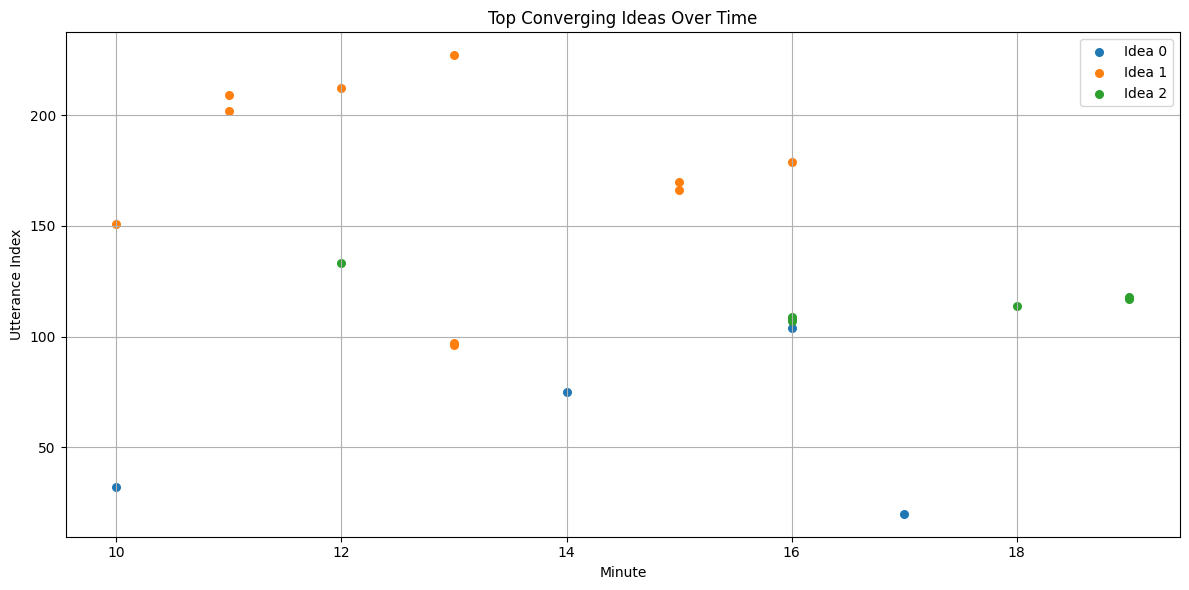


🧠 Core Utterance per Idea Cluster:

💡 Idea 0: Um,

💡 Idea 1: Yeah.

💡 Idea 2: Right.


In [108]:
# --- Step 0: Imports ---
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# --- Step 1: Load and Filter Session ---
session_id = "2021_05_21_ABI_S15_ABI"
df_full = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")
df_session = df_full[df_full['global_session'] == session_id].copy()

if df_session.empty:
    raise ValueError(f"No valid data for session: {session_id}")

df_session = df_session.dropna(subset=['transcript']).reset_index(drop=True)

# --- Step 2: Compute SBERT Embeddings ---
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_session['transcript'].tolist(), show_progress_bar=True)

# --- Step 3: Cluster Utterances into Semantic Ideas using DBSCAN ---
cos_dist = cosine_distances(embeddings)  # ✅ Fixed .cpu().numpy() bug
clustering = DBSCAN(metric="precomputed", eps=0.25, min_samples=3)
labels = clustering.fit_predict(cos_dist)
df_session['idea_cluster'] = labels

# --- Step 4: Add Annotation Markers and Metadata ---
df_session['minute'] = df_session['global_timestamp_sec'].astype(float) // 60
df_session['minute'] = df_session['minute'].astype(int)

df_session['annotation_list'] = df_session['annotations'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) and x.startswith("[") else []
)
df_session['is_proposer'] = df_session['annotation_list'].apply(lambda x: 'has_new_idea' in x)
df_session['is_expansion'] = df_session['annotation_list'].apply(lambda x: 'has_explanation' in x)

# --- Step 5: Debug Annotation Coverage ---
print("\n🔍 Annotation Diagnostic:")
print(df_session['annotation_list'].explode().value_counts())
print(f"% Utterances with new idea: {df_session['is_proposer'].mean() * 100:.2f}%")
print(f"% Utterances with explanation: {df_session['is_expansion'].mean() * 100:.2f}%")

# --- Step 6: Score Each Cluster for Convergence ---
cluster_stats = (
    df_session[df_session['idea_cluster'] != -1]
    .groupby('idea_cluster')
    .agg(
        n_utterances=('transcript', 'count'),
        n_minutes=('minute', pd.Series.nunique),
        n_speakers=('speaker', pd.Series.nunique),
        n_proposers=('is_proposer', 'sum'),
        n_expansions=('is_expansion', 'sum')
    )
    .sort_values(by='n_expansions', ascending=False)
    .reset_index()
)

print("\n📊 Top Idea Clusters by Expansion Count:")
display(cluster_stats.head())

# --- Step 7: Visualize Top Converging Ideas Over Time ---
top_n = 5
palette = sns.color_palette("tab10", n_colors=top_n)
df_plot = df_session[df_session['idea_cluster'].isin(cluster_stats['idea_cluster'].head(top_n))].copy()

plt.figure(figsize=(12, 6))
for i, (cluster_id, group) in enumerate(df_plot.groupby('idea_cluster')):
    plt.scatter(group['minute'], group.index, label=f"Idea {cluster_id}", s=30, color=palette[i])
plt.xlabel("Minute")
plt.ylabel("Utterance Index")
plt.title("Top Converging Ideas Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 8 (Optional): Display Core Utterance for Each Top Idea ---
print("\n🧠 Core Utterance per Idea Cluster:")
for cluster_id in cluster_stats['idea_cluster'].head(top_n):
    idxs = df_session[df_session['idea_cluster'] == cluster_id].index
    emb_sub = embeddings[idxs]
    centroid = emb_sub.mean(axis=0, keepdims=True)
    dists = pairwise_distances(centroid, emb_sub)[0]
    central_utt = df_session.loc[idxs[dists.argmin()], 'transcript']
    print(f"\n💡 Idea {cluster_id}: {central_utt}")


# Idea Convergence Bursts and Speaker Contributions



/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_30477/3251570894.py:22: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


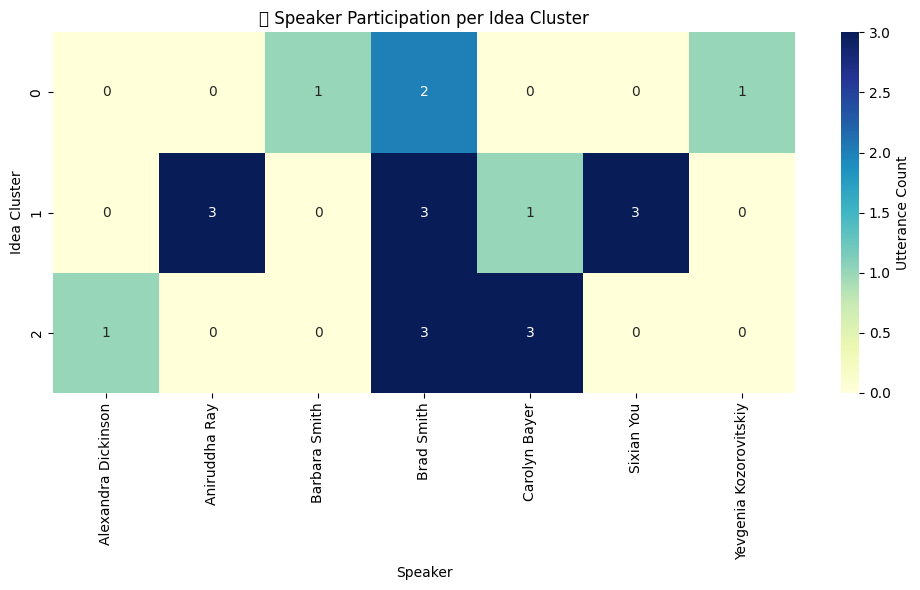

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_30477/3251570894.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


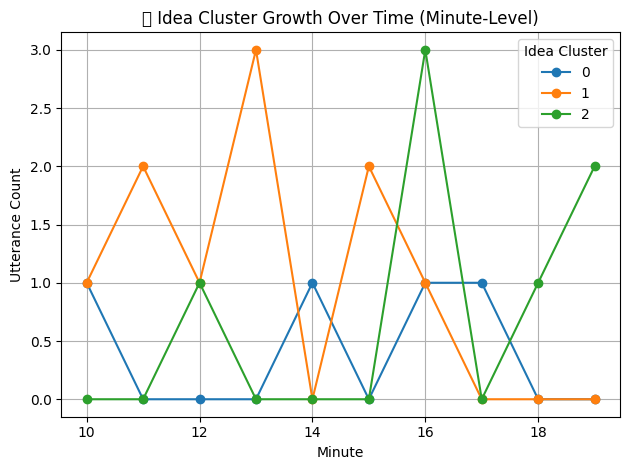

🌟 Ranked Finalist Solution Candidates:


,idea_cluster,score,n_expansions,n_speakers,n_minutes
1,1,1.4,0,4,6
0,0,1.1,0,3,4
2,2,1.1,0,3,4


In [111]:
# --- Step 9: Heatmap of Speaker vs Idea Cluster (Engagement Matrix) ---
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to top ideas
top_ideas = cluster_stats['idea_cluster'].head(top_n).tolist()
df_heat = df_session[df_session['idea_cluster'].isin(top_ideas)]

# Build speaker vs idea matrix
speaker_idea_matrix = (
    df_heat.groupby(['idea_cluster', 'speaker'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(10, 6))
sns.heatmap(speaker_idea_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Utterance Count'})
plt.title("🧠 Speaker Participation per Idea Cluster")
plt.xlabel("Speaker")
plt.ylabel("Idea Cluster")
plt.tight_layout()
plt.show()

# --- Optional: Idea Cluster Evolution Over Time ---
df_evolution = (
    df_session[df_session['idea_cluster'].isin(top_ideas)]
    .groupby(['minute', 'idea_cluster'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(12, 6))
df_evolution.plot(marker='o')
plt.title("📈 Idea Cluster Growth Over Time (Minute-Level)")
plt.xlabel("Minute")
plt.ylabel("Utterance Count")
plt.legend(title="Idea Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()
# --- Optional: Rank Finalist Solution Candidates ---
cluster_stats['score'] = (
    cluster_stats['n_expansions'] +
    0.5 * cluster_stats['n_speakers'] -
    0.1 * cluster_stats['n_minutes']  # penalize overly long diffusion
)

ranked_candidates = cluster_stats.sort_values(by='score', ascending=False)

print("🌟 Ranked Finalist Solution Candidates:")
display(ranked_candidates.head(5)[['idea_cluster', 'score', 'n_expansions', 'n_speakers', 'n_minutes']])




In [112]:
# --- Step: Summarize + Label Top Idea Clusters (Convergence Outcomes) ---
from transformers import pipeline
import pandas as pd

# Load summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Set how many top clusters to process
top_k = 3
summaries = []
labels = []

# Define quick heuristic labeling function
def label_cluster(row):
    if row['n_expansions'] >= 2 and row['n_speakers'] >= 3:
        return "Emerging Solution"
    elif row['n_expansions'] == 0:
        return "Possibly Stalled"
    else:
        return "Exploratory"

# Process top idea clusters
for i, row in ranked_candidates.head(top_k).iterrows():
    cluster_id = row['idea_cluster']
    df_cluster = df_session[df_session['idea_cluster'] == cluster_id]
    text = " ".join(df_cluster['transcript'].tolist())
    
    # Summarize the idea if text is long enough
    if len(text.split()) > 80:
        text = text[:1024]  # truncate for BART
        summary = summarizer(text, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
    else:
        summary = "Too short for summarization."

    # Label the cluster
    cluster_label = label_cluster(row)

    summaries.append({
        "idea_cluster": cluster_id,
        "score": row['score'],
        "label": cluster_label,
        "n_expansions": row['n_expansions'],
        "n_speakers": row['n_speakers'],
        "n_minutes": row['n_minutes'],
        "summary": summary
    })

# Convert to DataFrame
df_finalists = pd.DataFrame(summaries)

# Display as final report
print("\n🌟 Finalist Idea Clusters (Summarized + Labeled):")
display(df_finalists[['idea_cluster', 'label', 'score', 'n_expansions', 'n_speakers', 'n_minutes']])
for _, row in df_finalists.iterrows():
    print(f"\n🧠 Idea {row['idea_cluster']} ({row['label']}):\n{row['summary']}")


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



🌟 Finalist Idea Clusters (Summarized + Labeled):


,idea_cluster,label,score,n_expansions,n_speakers,n_minutes
0,1.0,Possibly Stalled,1.4,0.0,4.0,6.0
1,0.0,Possibly Stalled,1.1,0.0,3.0,4.0
2,2.0,Possibly Stalled,1.1,0.0,3.0,4.0



🧠 Idea 1.0 (Possibly Stalled):
Too short for summarization.

🧠 Idea 0.0 (Possibly Stalled):
Too short for summarization.

🧠 Idea 2.0 (Possibly Stalled):
Too short for summarization.


## Cluster Review - Summary and Sample Transcripts (Converging Ideas)

In [113]:
# --- Step 10: Extract and Summarize Top Idea Clusters ---
from transformers import pipeline
import textwrap

# Load summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Choose how many top clusters to summarize
top_clusters = ranked_candidates['idea_cluster'].head(top_n).tolist()

for cluster_id in top_clusters:
    cluster_utterances = df_session[df_session['idea_cluster'] == cluster_id]
    transcript_text = " ".join(cluster_utterances['transcript'].tolist())

    print(f"\n🧠 Idea {cluster_id:.1f} Summary:")
    if len(transcript_text.split()) < 50:
        print("Too short for summarization.")
    else:
        chunks = [transcript_text[i:i+1000] for i in range(0, len(transcript_text), 1000)]
        summaries = [summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text'] for chunk in chunks]
        full_summary = "\n".join(summaries)
        print(textwrap.fill(full_summary, width=100))

    print("\n🔎 Sample Utterances:")
    for _, row in cluster_utterances.head(3).iterrows():
        print(f"- {row['speaker']}: {row['transcript']}")


/opt/miniconda3/envs/conv-clean/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



🧠 Idea 1.0 Summary:
Too short for summarization.

🔎 Sample Utterances:
- Sixian You: Yeah.
- Sixian You: Yeah.
- Sixian You: Yeah.

🧠 Idea 0.0 Summary:
Too short for summarization.

🔎 Sample Utterances:
- Barbara Smith: Um
- Brad Smith: Um, well,
- Brad Smith: So um,

🧠 Idea 2.0 Summary:
Too short for summarization.

🔎 Sample Utterances:
- Carolyn Bayer: Right.
- Brad Smith: Right.
- Brad Smith: Right.


# TAKE AWAYS FROM SBERT / DBSCAN

From what I was able to work out across primarily two different conference sessions, this partially works but not fully.

- This can identify semantically dense utterance clusters in real transcript data

- Associate those clusters with time, speakers, and annotations

- Create a shared object `idea_cluster` that could analyze and visualize

## Still some failure points

- Didn't consistenly surface meaningful "ideas" with enough richness to summarize

- Didn't align well with the annotatoins in sparse or noisy sessions

- Some formed clusters around filler phrases ("um", "yeah") or disjointed content

# COULD TRY THIS NEXT (make another ipynb file?)

## Time-windowed embedding clustering (Temporal SBERT)

## Graph-based co-expansion modeling

## Latent topic models w/ time awareness 

- BERTopic (built on SBERT + HDSCAN + c-TF-IDF)

- Top2Vec (builds topic vectors from SBERT)

- Dynamic Topic Models (DTM) evolution over time

**by this you could possibly get topic words and link those to solution emergence**

## Conversation turn-based modeling

## Annotation-aware filtering before clustering

## Transformer-based summarization chains




# Clean Step‑2 Sandbox: Toggle Experiments (added by assistant)

This self-contained section gives you **one clean place** to iterate without touching the rest of your notebook.

**What it does**
- Reads your existing Gemini-annotated Excel (one meeting)
- Applies minimal, toggleable preprocessing (micro-turn merge, filler filter, min length)
- Computes **windowed** sentence embeddings (SBERT-ready)
- Builds an **adjacent cosine similarity** curve
- Detects **convergence bursts** by z-score or percentile threshold
- Overlays **annotation-aware metrics** (overlap with codes, speaker mix at onset, novelty)
- Produces a **timeline plot** and an **arcs table** you can show Evey

> Tip: Run cells **top to bottom** inside this section. You can duplicate this block and save variants if you like.


In [ ]:

# ======================
# CONFIG (edit here)
# ======================

# Path to your Gemini Excel (one meeting)
EXCEL_PATH = "data/your_meeting.xlsx"   # <-- change me to your actual file path

# Session ID label for plots/tables
SESSION_ID = "2021_09_30_MZT_S7"

# Preprocessing toggles
MERGE_MICRO_TURNS = True
MICROTURN_MERGE_SECONDS = 2.5
ENABLE_FILLER_FILTER = True
MIN_TOKENS_PER_UTT = 5
FILLER_LEXICON = ("um", "uh", "yeah", "okay", "ok", "right", "mm", "hmm")

# Embedding window (use odd numbers like 3 or 5)
USE_SLIDING_WINDOW = True
WINDOW_SIZE_UTTS = 3

# Thresholding for burst detection
THRESHOLD_MODE = "zscore"   # "zscore" | "percentile"
Z_ABOVE = 1.0               # for zscore mode
TOP_P = 0.10                # for percentile mode (top 10%)

# Burst shape
MIN_ARC_LEN_UTTS = 4
MIN_GAP_UTTS = 3

# Codes to align with
MASK_CODES = ("has_new_idea", "has_explanation", "has_decision")

# Output toggles
SHOW_TABLE = True
SAVE_PLOT = False   # set True to save to disk
PLOT_PATH = f"timeline_{SESSION_ID}.png"


In [ ]:

# Imports for the sandbox
import re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple

# Optional: Uncomment when you have the environment ready
# from sentence_transformers import SentenceTransformer


In [ ]:

# ===============
# LOADER
# ===============
def load_gemini_excel(path: str) -> pd.DataFrame:
    df = pd.read_excel(path)
    # Heuristic timestamp handling
    if 'timestamp_sec' not in df.columns:
        if 'timestamp' in df.columns:
            try:
                # Try HH:MM:SS
                ts = pd.to_timedelta(df['timestamp'])
                df['timestamp_sec'] = ts.dt.total_seconds()
            except Exception:
                if pd.api.types.is_datetime64_any_dtype(df.get('timestamp')):
                    df['timestamp_sec'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
                else:
                    df['timestamp_sec'] = pd.to_numeric(df.get('timestamp'), errors='coerce')
    # Normalize columns we rely on
    for col in ['speaker','transcript','annotations']:
        if col not in df.columns:
            df[col] = ""
        df[col] = df[col].fillna("").astype(str)
    if 'speaking_duration' not in df.columns:
        df['speaking_duration'] = 0.0
    df = df.sort_values('timestamp_sec').reset_index(drop=True)
    return df


In [ ]:

# =================
# PREPROCESSING
# =================

def is_filler(text: str, filler_lexicon) -> bool:
    t = (text or "").strip().lower()
    toks = re.findall(r"[a-z']+", t)
    if not toks:
        return True
    filler_count = sum(1 for tok in toks if tok in filler_lexicon)
    return filler_count / max(1, len(toks)) >= 0.5

def merge_micro_turns(df: pd.DataFrame, merge_seconds: float) -> pd.DataFrame:
    rows = []
    cur = None
    for _, row in df.iterrows():
        r = row.to_dict()
        r['end_time_sec'] = r['timestamp_sec'] + float(r.get('speaking_duration', 0) or 0)
        if cur is None:
            cur = r
            continue
        same = r['speaker'] == cur['speaker']
        gap = r['timestamp_sec'] - cur['end_time_sec']
        if same and 0 <= gap <= merge_seconds:
            cur['transcript'] = (cur['transcript'] + " " + r['transcript']).strip()
            cur['end_time_sec'] = r['timestamp_sec'] + float(r.get('speaking_duration', 0) or 0)
        else:
            rows.append(cur)
            cur = r
    if cur is not None:
        rows.append(cur)
    return pd.DataFrame(rows)

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if MERGE_MICRO_TURNS:
        out = merge_micro_turns(out, MICROTURN_MERGE_SECONDS)
    if ENABLE_FILLER_FILTER:
        out = out[~out['transcript'].apply(lambda t: is_filler(t, FILLER_LEXICON))].copy()
    out['n_tokens'] = out['transcript'].str.split().apply(len)
    out = out[out['n_tokens'] >= MIN_TOKENS_PER_UTT].copy()
    out = out.reset_index(drop=True)
    return out


In [ ]:

# =================
# EMBEDDINGS
# =================

# Plug in your SentenceTransformer here when ready:
# model = SentenceTransformer('all-MiniLM-L6-v2')

def _window_texts(texts: List[str], k: int) -> List[str]:
    if not USE_SLIDING_WINDOW:
        return texts
    half = k // 2
    win = []
    for i in range(len(texts)):
        s = max(0, i - half)
        e = min(len(texts), i + half + 1)
        win.append(" ".join(texts[s:e]))
    return win

def embed_utterances(texts: List[str], k: int = 3) -> np.ndarray:
    win_texts = _window_texts(texts, k) if USE_SLIDING_WINDOW else texts
    # Placeholder embedding: replace with SBERT embeddings for real runs
    # E = model.encode(win_texts, show_progress_bar=False, normalize_embeddings=True)
    E = np.array([[len(t) % 17, len(t) % 23, len(t) % 29] for t in win_texts], dtype=float)
    # L2-normalize
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-8
    return E / norms


In [ ]:

# ============================
# SIMILARITY & BURST DETECTION
# ============================

def adjacent_similarity(embs: np.ndarray) -> np.ndarray:
    # cosine sim with next (i,i+1), pad last with self-sim=1.0
    sims = []
    for i in range(len(embs)):
        j = i+1 if i+1 < len(embs) else i
        sims.append(float(np.dot(embs[i], embs[j])))
    return np.array(sims)

def detect_bursts(sim_series: np.ndarray) -> list:
    x = sim_series.copy()
    if THRESHOLD_MODE == "zscore":
        mu = np.nanmean(x); sd = np.nanstd(x) + 1e-8
        mask = (x - mu) / sd >= Z_ABOVE
    elif THRESHOLD_MODE == "percentile":
        thr = np.nanpercentile(x, 100 * (1 - TOP_P))
        mask = x >= thr
    else:
        raise ValueError("Unknown THRESHOLD_MODE")

    # mask -> spans
    spans = []
    i = 0
    while i < len(mask):
        if mask[i]:
            j = i
            while j+1 < len(mask) and mask[j+1]:
                j += 1
            if (j - i + 1) >= MIN_ARC_LEN_UTTS:
                spans.append((i, j))
            i = j + 1
        else:
            i += 1

    # merge close spans
    merged = []
    for s in spans:
        if not merged:
            merged.append(s)
        else:
            p0, p1 = merged[-1]
            if s[0] - p1 - 1 <= MIN_GAP_UTTS:
                merged[-1] = (p0, s[1])
            else:
                merged.append(s)
    return merged


In [ ]:

# =================
# METRICS + PLOTTING
# =================

def jaccard_overlap(span_a, span_b):
    a = set(range(span_a[0], span_a[1]+1))
    b = set(range(span_b[0], span_b[1]+1))
    inter = len(a & b)
    union = len(a | b)
    return inter / max(1, union)

def code_spans(df: pd.DataFrame, codes) -> list:
    # crude: any of the codes appears in annotations string
    has = df['annotations'].str.contains("|".join(codes), case=False, na=False)
    spans = []
    i = 0
    while i < len(has):
        if has.iloc[i]:
            j = i
            while j+1 < len(has) and has.iloc[j+1]:
                j += 1
            spans.append((i, j))
            i = j + 1
        else:
            i += 1
    return spans

def speaker_mix_at_onset(df: pd.DataFrame, arcs, onset_utts=3):
    mixes = []
    for (s,e) in arcs:
        span = df.iloc[s:min(e, s+onset_utts)+1]
        mixes.append(span['speaker'].value_counts().to_dict())
    return mixes

def arc_novelty(embs: np.ndarray, start: int, end: int) -> float:
    arc_c = embs[start:end+1].mean(axis=0)
    hist_c = embs[:max(1,start)].mean(axis=0)
    # 1 - cosine
    return float(1.0 - np.dot(arc_c, hist_c) / ((np.linalg.norm(arc_c)+1e-8)*(np.linalg.norm(hist_c)+1e-8)))

def plot_timeline(sim_series, arcs, title="Similarity with convergence arcs"):
    plt.figure()
    plt.plot(range(len(sim_series)), sim_series, linewidth=1.5)
    for (s,e) in arcs:
        plt.axvspan(s, e, alpha=0.2)
    plt.xlabel("Utterance index")
    plt.ylabel("Adj. cosine similarity")
    plt.title(title)
    plt.tight_layout()
    if SAVE_PLOT:
        plt.savefig(PLOT_PATH)
    plt.show()


In [ ]:

# =================
# RUN EXPERIMENT
# =================

df_raw = load_gemini_excel(EXCEL_PATH)
df = preprocess(df_raw)

embs = embed_utterances(df['transcript'].tolist(), k=WINDOW_SIZE_UTTS)
sim_series = adjacent_similarity(embs)
arcs = detect_bursts(sim_series)

# Metrics
spans = code_spans(df, MASK_CODES)
overlaps = []
novelties = []
mixes = []
for (s,e) in arcs:
    best = 0.0
    for c in spans:
        best = max(best, jaccard_overlap((s,e), c))
    overlaps.append(best)
    novelties.append(arc_novelty(embs, s, e))
    mixes.append(speaker_mix_at_onset(df, [(s,e)], onset_utts=3)[0])

# Table
rows = []
for i, ((s,e), ov, nv, mx) in enumerate(zip(arcs, overlaps, novelties, mixes)):
    rows.append({
        "arc_id": i,
        "utt_start": s,
        "utt_end": e,
        "start_sec": float(df.iloc[s]["timestamp_sec"]),
        "end_sec": float(df.iloc[e]["timestamp_sec"]),
        "len_utts": e-s+1,
        "overlap_with_codes": ov,
        "novelty_1_minus_cos": nv,
        "speaker_mix_onset": json.dumps(mx)
    })
arcs_table = pd.DataFrame(rows)

plot_timeline(sim_series, arcs, title=f"{SESSION_ID}: Similarity with convergence arcs")

if SHOW_TABLE:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user(f"Arcs Table — {SESSION_ID}", arcs_table)

arcs_table.head(10)



---

### One-liner you can say to Evey
> “I carved out a clean Step‑2 sandbox in the same notebook. It runs windowed SBERT-style similarity on our Gemini meeting, detects convergence arcs by z‑score/percentile, and reports arc overlap with `{has_new_idea, has_explanation, has_decision}`, onset speaker mix, and novelty. Next, I’ll A/B the filler filter and window size to see which improves alignment most.”
